In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
import numpy as np
import glob
import os

label_mapping = {
      "none": 0,
      "left": 1,
      "center": 2,
      "right": 3
    }

def get_all_files_from_dirs(directories, extension="*.npy"):
  all_files = []
  for directory in directories:
    files = glob.glob(os.path.join(directory, extension))
    all_files.extend(files)

  return all_files



class Sequential2DDatasetWithLabels(Dataset):
  def __init__(self, data_dirs, label_dirs, transform=None, labels_transform=None):
    self.data_paths = get_all_files_from_dirs(data_dirs, "*.npy")
    self.label_paths = get_all_files_from_dirs(label_dirs, "*.npy")

    # ファイル名でソートしてラベルとデータの対応付けを保証
    self.data_paths.sort()
    self.label_paths.sort()

    self.transform = transform
    self.labels_transform = labels_transform

  def __len__(self):
    return len(self.data_paths)
  
  def __getitem__(self, idx):
    data = np.load(self.data_paths[idx])

    labels = np.load(self.label_paths[idx], allow_pickle=True)

    if self.transform:
      data = self.transform(data)
    
    if self.labels_transform:
      labels = self.labels_transform(labels)
    return data, labels

class NormalizePerSequence:
  def __call__(self, data):
    mean = data.mean()
    std = data.std()

    if std > 0:
      data = (data - mean) / std
    
    return data

class LabelMappingTransform:
  def __init__(self):
    self.label_mapping = label_mapping
  
  def __call__(self, labels):
    return torch.tensor([self.label_mapping[label] for label in labels], dtype=torch.long)

class DataToTensor:
  def __init__(self):
    self.normalize = NormalizePerSequence()

  def __call__(self, data):
    # データは L x 方向数(72) x 周波数
    data = torch.from_numpy(data).float()
    data = data[:, :, :65]
    data = data.unsqueeze(1) # L x 1 x 方向数(72) x 周波数 に変換
    return data
  
def collate_fn(batch):
  datas_batch, labels_batch = zip(*batch)
  lengths = torch.tensor([len(seq) for seq in datas_batch])
  padded_data = pad_sequence(datas_batch, batch_first=True, padding_value=0)
  padded_labels = pad_sequence(labels_batch, batch_first=True, padding_value=-1)

  return padded_data, padded_labels, lengths

In [2]:
# データセットの確認
from torch.utils.data import random_split

# 全て
# data_dirs = ["/home/nishimura-k/audioprocessing/datas/npy_MUSIC/150_ltor_data50", "/home/nishimura-k/audioprocessing/datas/npy_MUSIC/150_rtol_data50", "/home/nishimura-k/audioprocessing/datas/npy_MUSIC/EF/EF_ltor_150_0to59", "/home/nishimura-k/audioprocessing/datas/npy_MUSIC/EF/EF_rtol_150_0to59"]
# label_dirs = ["/home/nishimura-k/audioprocessing/datas/npy_AREA_label/150_ltor_data50", "/home/nishimura-k/audioprocessing/datas/npy_AREA_label/150_rtol_data50", "/home/nishimura-k/audioprocessing/datas/npy_AREA_label/EF/EF_ltor_150_0to59", "/home/nishimura-k/audioprocessing/datas/npy_AREA_label/EF/EF_rtol_150_0to59"]

# EFのみ
data_dirs = ["/home/nishimura-k/audioprocessing/datas/npy_MUSIC/EF/EF_ltor_150_0to59", "/home/nishimura-k/audioprocessing/datas/npy_MUSIC/EF/EF_rtol_150_0to59"]
label_dirs = ["/home/nishimura-k/audioprocessing/datas/npy_AREA_label/EF/EF_ltor_150_0to59", "/home/nishimura-k/audioprocessing/datas/npy_AREA_label/EF/EF_rtol_150_0to59"]



data_transform = DataToTensor()
label_transform = LabelMappingTransform()
batch_size = 2

dataset = Sequential2DDatasetWithLabels(data_dirs=data_dirs, label_dirs=label_dirs, transform=data_transform, labels_transform=label_transform)

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# dataloaderの実験用コード
for i, (batch_data, batch_labels, batch_lengths) in enumerate(train_dataloader):
  print(f"バッチ {i+1}")
  print(f"　データのサイズ: {batch_data.size()}")
  print(f"　ラベルのサイズ: {batch_labels.size()}")
  print(f"　シーケンスの元の長さ: {batch_lengths}")
  if i == 0:
    print(batch_data)

  packed_data = pack_padded_sequence(batch_data, batch_lengths, batch_first=True, enforce_sorted=False)

バッチ 1
　データのサイズ: torch.Size([2, 67, 1, 72, 65])
　ラベルのサイズ: torch.Size([2, 67])
　シーケンスの元の長さ: tensor([67, 67])
tensor([[[[[ 99.8428,  20.0058,   8.5268,  ...,  12.7463,  10.8008,
             17.1523],
           [ 99.8428,  20.0254,   8.5535,  ...,  14.5542,  12.1134,
             13.5072],
           [ 99.8428,  20.0495,   8.5808,  ...,  15.8491,  12.5149,
             10.5086],
           ...,
           [ 99.8428,  19.9738,   8.4519,  ...,   7.4176,   6.2453,
             19.7480],
           [ 99.8428,  19.9799,   8.4759,  ...,   8.9686,   7.5555,
             21.6231],
           [ 99.8428,  19.9906,   8.5009,  ...,  10.7903,   9.1349,
             20.4694]]],


         [[[ 54.0558,  45.8638,   3.8000,  ...,   4.0700,  14.2264,
              5.3214],
           [ 54.0558,  45.9507,   3.7934,  ...,   4.6217,  18.0325,
              6.2224],
           [ 54.0558,  46.0148,   3.7865,  ...,   5.2226,  22.2257,
              7.3183],
           ...,
           [ 54.0558,  45.4751,   3.81

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CNNLSTMClassifier(nn.Module):
  def __init__(self, hidden_size, output_size):
    super(CNNLSTMClassifier, self).__init__()
    self.layer1 = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2, 2))
    )
    self.layer2 = nn.Sequential(
      nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2, 2))
    )
    self.layer3 = nn.Sequential(
      nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2, 2))
    )
    self.lstm = nn.LSTM(input_size=64 * 9 * 8, hidden_size=hidden_size)
    self.fc = nn.Linear(hidden_size, output_size)
  
  def forward(self, x, lengths):
    batch_size, seq_len, channels, height, width = x.size()
    cnn_features = []
    # Convを実行
    for t in range(seq_len):
      frame = x[:, t, :, :, :]
      cnn_out = self.layer1(frame)
      cnn_out = self.layer2(cnn_out)
      cnn_out = self.layer3(cnn_out)
      cnn_out = cnn_out.view(batch_size, -1)
      cnn_features.append(cnn_out)
    
    cnn_features = torch.stack(cnn_features, dim=1)
    packed_input = rnn_utils.pack_padded_sequence(cnn_features, lengths, batch_first=True, enforce_sorted=False)
    packed_output, (hn, cn) = self.lstm(packed_input)

    lstm_out, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
    out = self.fc(lstm_out)
    return out


FOLD 0
-------------------------------
epoch 1/25, Train Loss: 0.5222557686890165
epoch 1/25, Valid Loss: 0.39211927602688473
Validation accuracy for fold 0: 85.77307466196355%
epoch 2/25, Train Loss: 0.27285615509996813
epoch 2/25, Valid Loss: 0.33877895151575405
Validation accuracy for fold 0: 87.3015873015873%
epoch 3/25, Train Loss: 0.22881974248836437
epoch 3/25, Valid Loss: 0.3519775904715061
Validation accuracy for fold 0: 87.41916519694297%
epoch 4/25, Train Loss: 0.21327795491864285
epoch 4/25, Valid Loss: 0.4557746772964795
Validation accuracy for fold 0: 80.89359200470311%
epoch 5/25, Train Loss: 0.20490553633620343
epoch 5/25, Valid Loss: 0.46324554334084195
Validation accuracy for fold 0: 83.48030570252793%
epoch 6/25, Train Loss: 0.16511336574330926
epoch 6/25, Valid Loss: 0.2699521481990814
Validation accuracy for fold 0: 90.88771310993533%
epoch 7/25, Train Loss: 0.13335098652169108
epoch 7/25, Valid Loss: 0.3971167455116908
Validation accuracy for fold 0: 83.8330393885

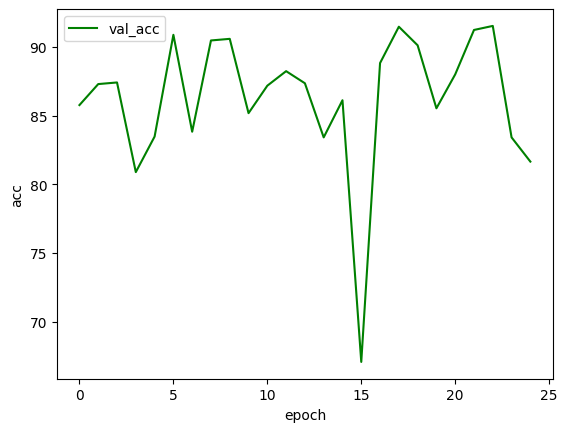

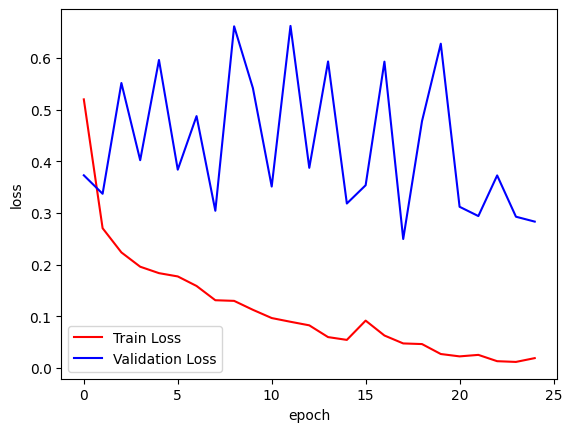

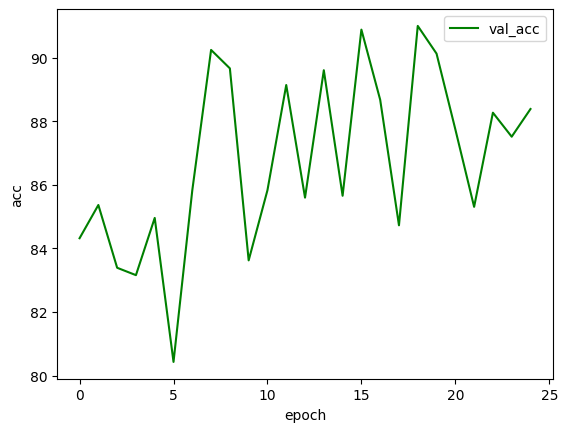

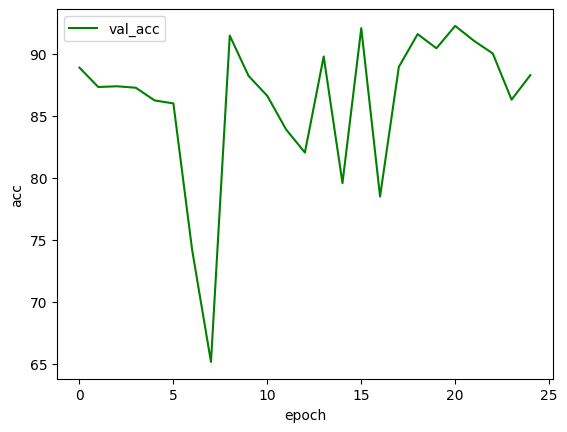

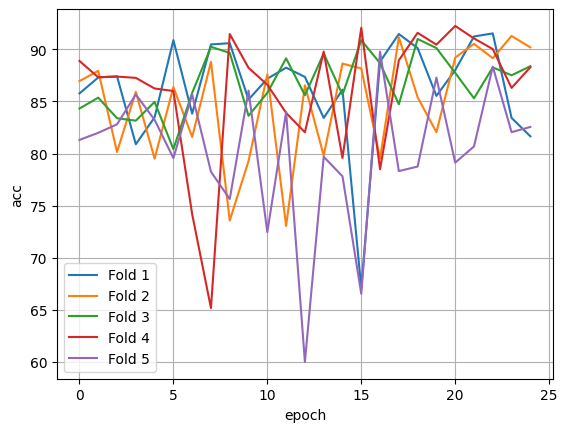

In [4]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold

k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)
hidden_size = 1024
output_size = len(label_mapping)


acc_fold = []

for fold, (train_ids, valid_ids) in enumerate(kfold.split(dataset)):
  print(f"FOLD {fold}")
  print("-------------------------------")

  train_subsampler = Subset(dataset, train_ids)
  valid_subsampler = Subset(dataset, valid_ids)

  trainloader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  validloader = DataLoader(valid_subsampler, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

  model = CNNLSTMClassifier(hidden_size, output_size).to(device)
  criterion = nn.CrossEntropyLoss(ignore_index=-1)
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  torch.cuda.empty_cache()
  num_epochs = 25

  train_loss_list = []
  val_loss_list = []
  accuracy_list = []  

  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels, lengths) in enumerate(trainloader):
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs, lengths)
      loss = criterion(outputs.view(-1, output_size), labels.view(-1))

      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      torch.cuda.empty_cache()
  
    print(f"epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(trainloader)}")
    train_loss_list.append(running_loss/len(trainloader))
    
    model.eval()
    running_val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
      for inputs, labels, lengths in validloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs, lengths)

        val_loss = criterion(outputs.view(-1, output_size), labels.view(-1))
        running_val_loss += val_loss.item()

        _, predicted = torch.max(outputs, -1)
        valid_mask = labels != -1
        correct += (predicted[valid_mask] == labels[valid_mask]).sum().item()
        total += valid_mask.sum().item()
    
    avg_val_loss = running_val_loss / len(validloader)
    val_loss_list.append(avg_val_loss)
    accuracy = 100 * correct / total
    print(f"epoch {epoch+1}/{num_epochs}, Valid Loss: {avg_val_loss}")
    print(f"Validation accuracy for fold {fold}: {accuracy}%")
    accuracy_list.append(accuracy)

    if epoch == num_epochs-1:
      name = f"CNNLSTMClassifier{fold}.pth"
      torch.save(model.state_dict(), name)

      '''結果の表示'''
      plt.figure()
      plt.plot(range(num_epochs), train_loss_list, 'r-', label='Train Loss')
      plt.plot(range(num_epochs), val_loss_list, "b-", label="Validation Loss")
      plt.plot()
      plt.legend()
      plt.xlabel('epoch')
      plt.ylabel('loss')
      plt.figure()
      plt.plot(range(num_epochs), accuracy_list, 'g-', label='val_acc')
      plt.legend()
      plt.xlabel('epoch')
      plt.ylabel('acc')
      acc_fold.append(accuracy_list)

plt.figure()
for i in range(len(acc_fold)):
  plt.plot(range(num_epochs), acc_fold[i], label=f"Fold {i+1}")

plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.grid(True)


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataloader, device):
    model.eval()
    
    with torch.no_grad():
        for i, (inputs, labels, lengths) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs, lengths)
            _, predicted = torch.max(outputs, -1)

            # バッチの最初のシーケンスを可視化
            for batch_idx in range(inputs.size(0)):
                seq_len = lengths[batch_idx].item()
                true_labels = labels[batch_idx, :seq_len].cpu().numpy()
                pred_labels = predicted[batch_idx, :seq_len].cpu().numpy()

                # 可視化関数を呼び出す
                plot_sequence(true_labels, pred_labels, seq_len, i, batch_idx)

# シーケンスごとのラベルと予測をプロットする
def plot_sequence(true_labels, pred_labels, seq_len, batch_num, seq_num):
    plt.figure(figsize=(10, 4))
    
    time_steps = np.arange(seq_len)
    
    # 正解ラベル
    plt.plot(time_steps, true_labels, label='True Labels', color='g', marker='o')
    
    # 予測ラベル
    plt.plot(time_steps, pred_labels, label='Predicted Labels', color='r', linestyle='--', marker='x')
    
    plt.xlabel('Time Steps')
    plt.ylabel('Label')
    plt.title(f'Batch {batch_num}, Sequence {seq_num}')
    plt.legend()
    plt.show()



In [ ]:
# モデルの評価結果を可視化
model = CNNLSTMClassifier(hidden_size, output_size).to(device)
model.load_state_dict(torch.load("/home/nishimura-k/audioprocessing/algo_ml/EF_std_trimed_CNNLSTMClassifier/CNNLSTMClassifier0.pth"))
visualize_predictions(model, test_dataloader, device)

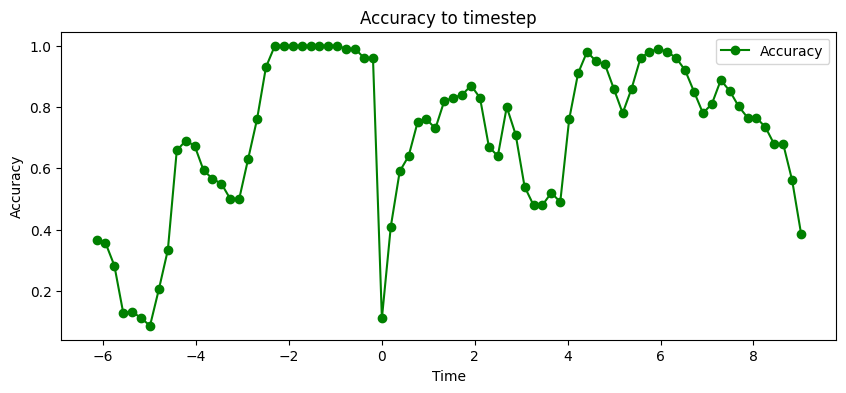

50
Valid Loss: 0.7682241690158844
Validation accuracy: 75.88622670589884%


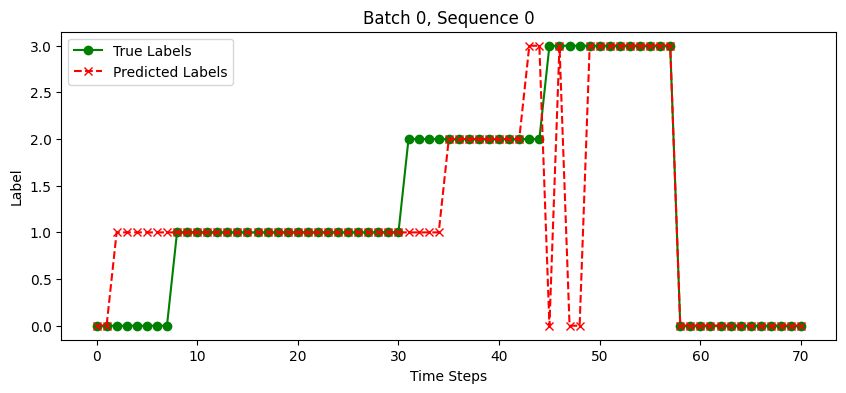

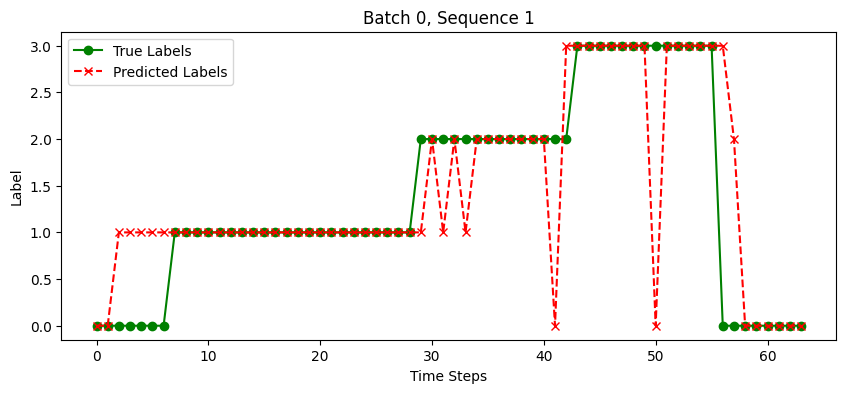

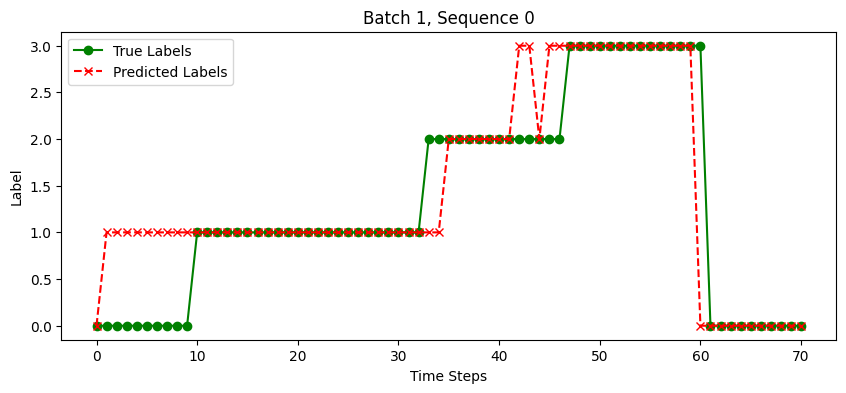

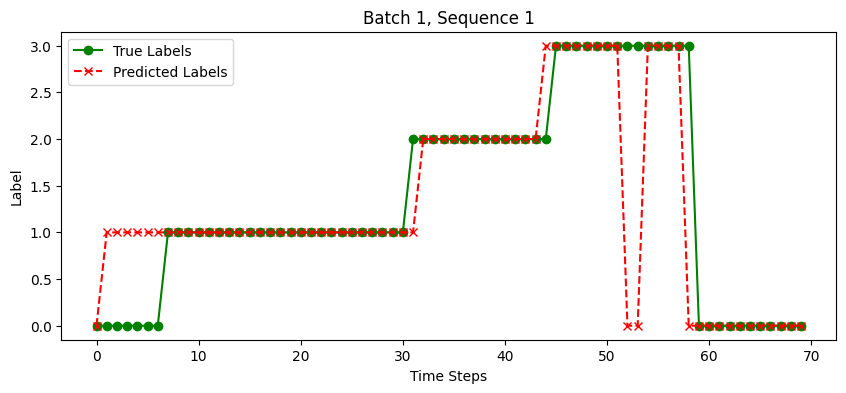

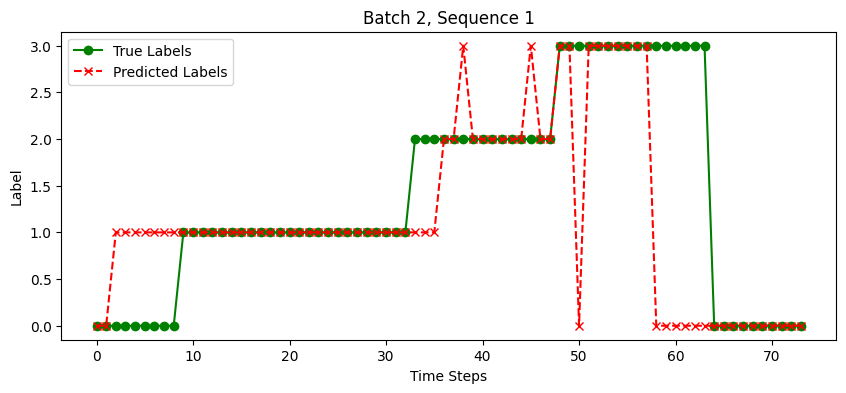

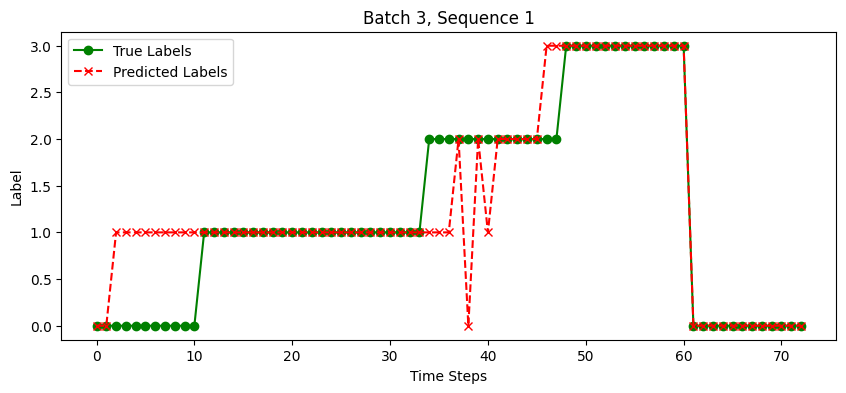

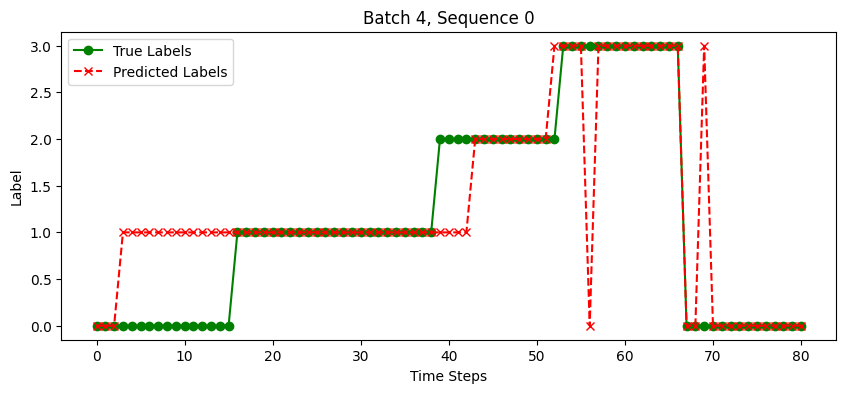

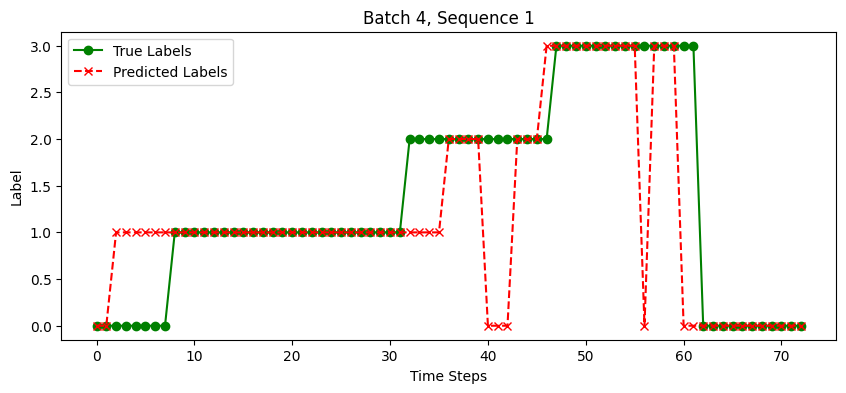

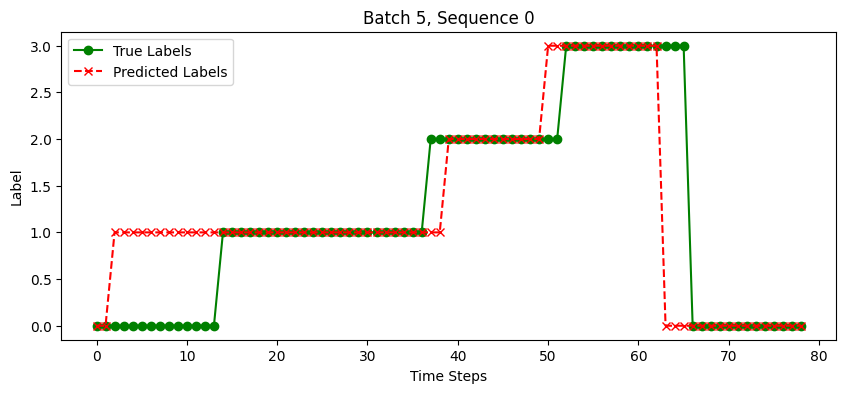

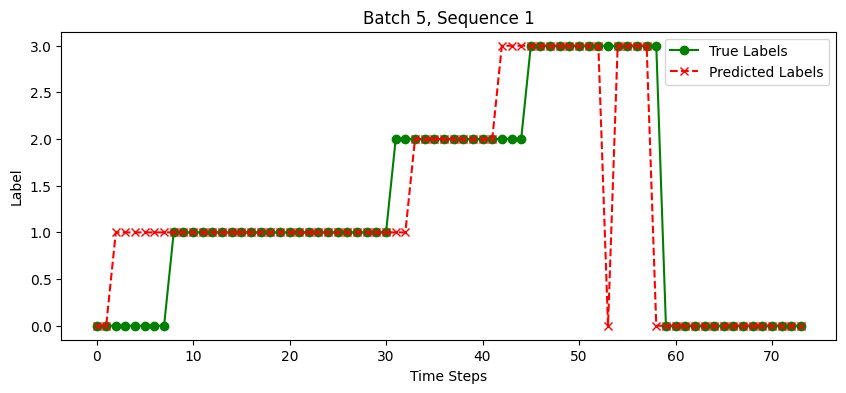

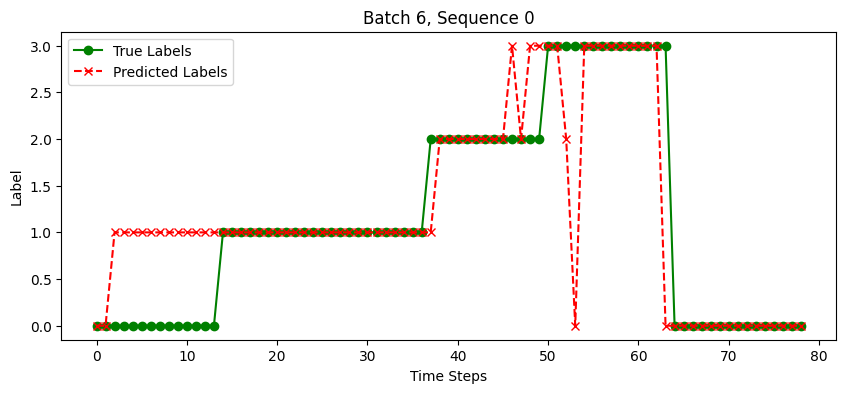

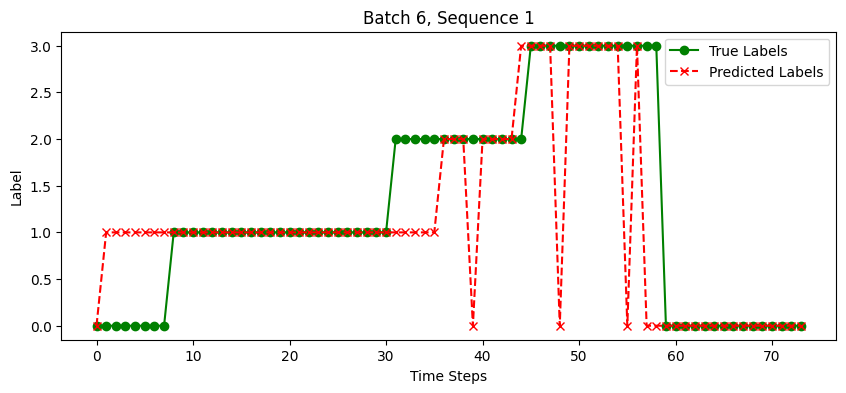

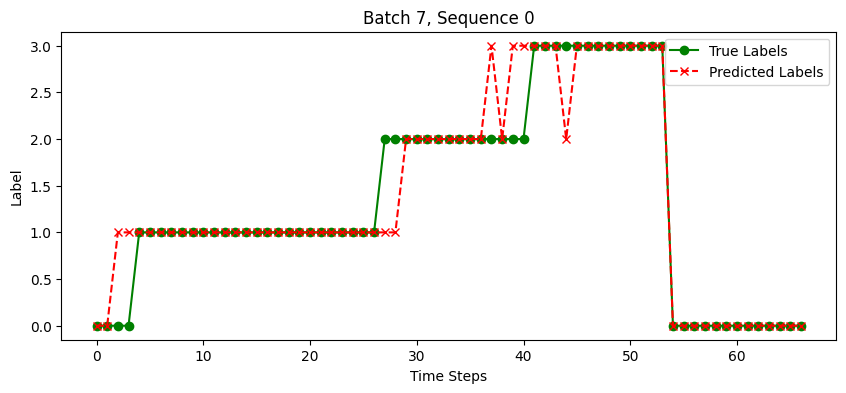

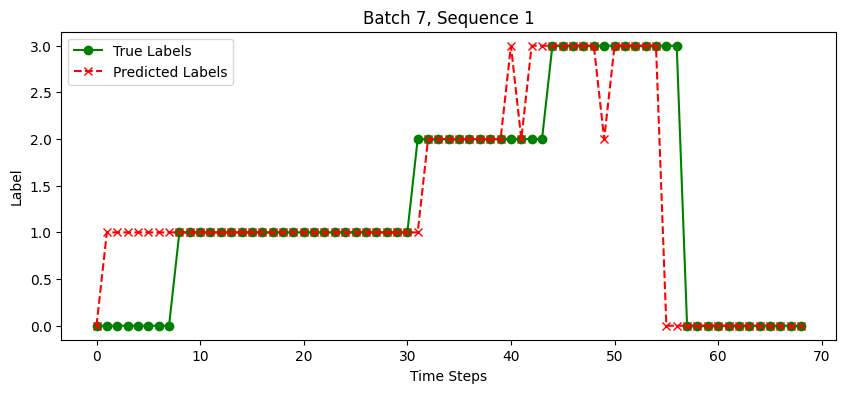

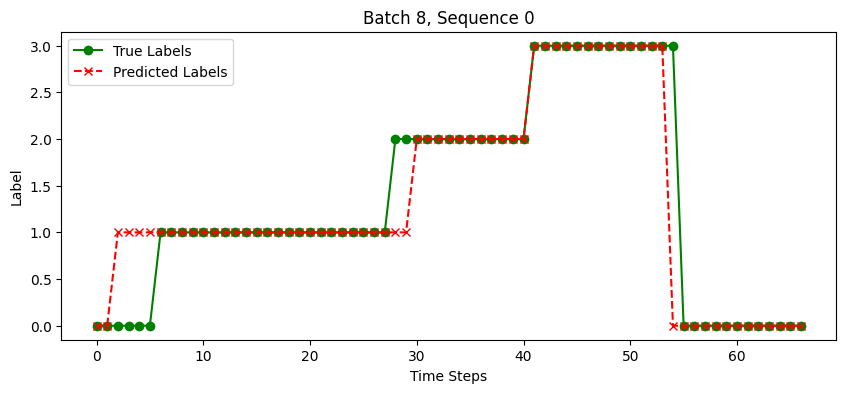

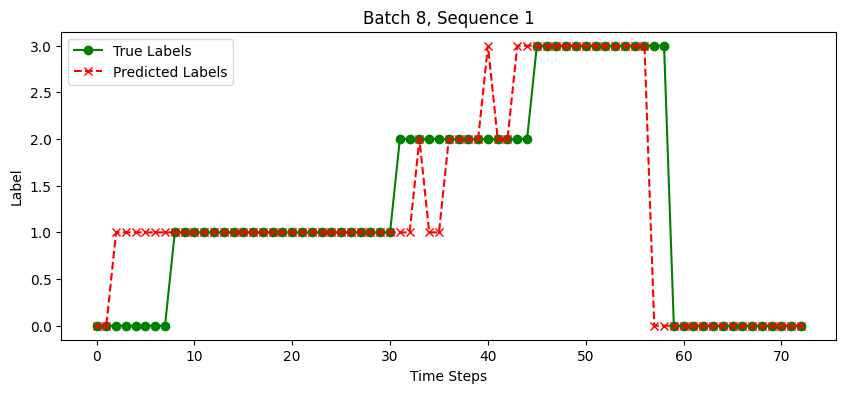

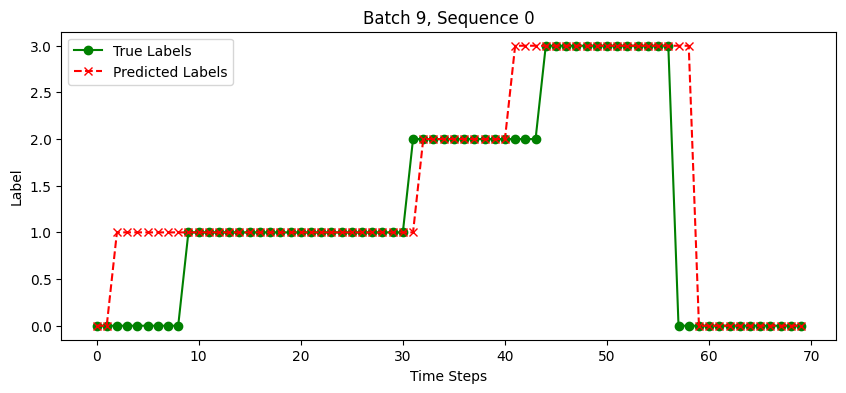

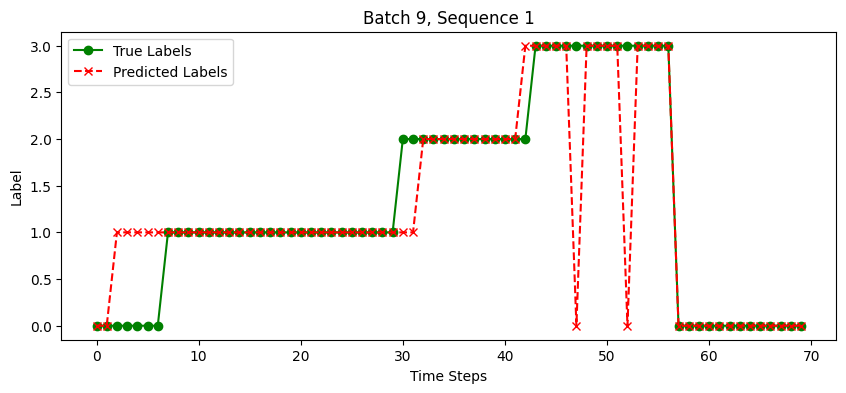

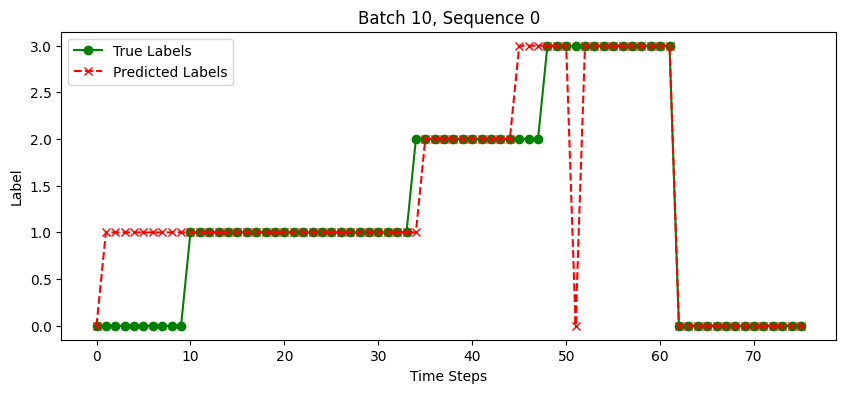

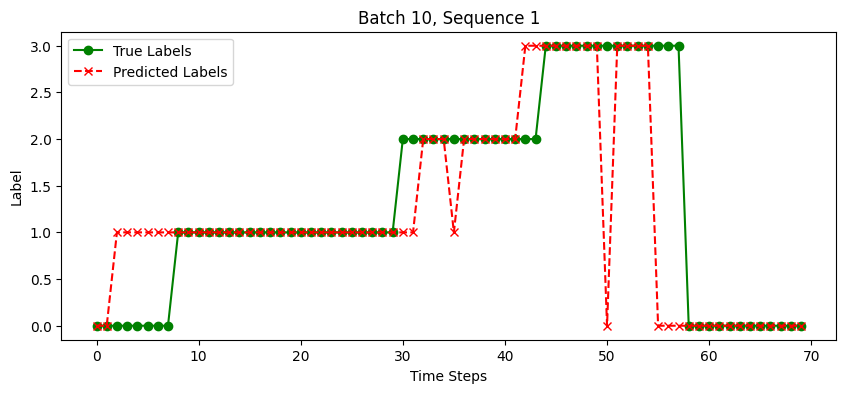

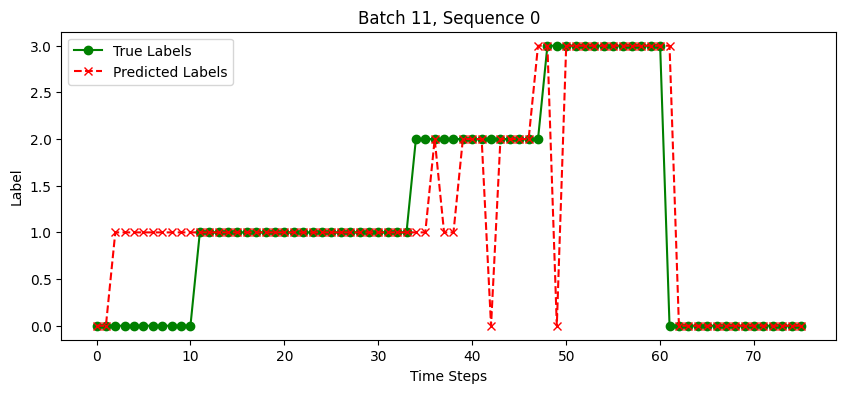

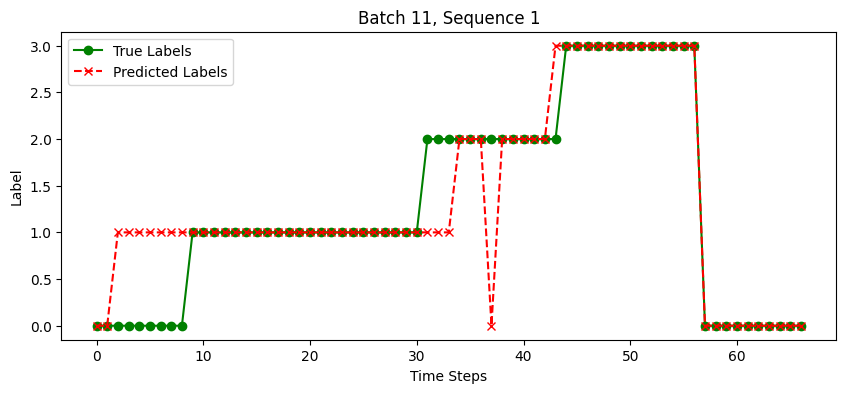

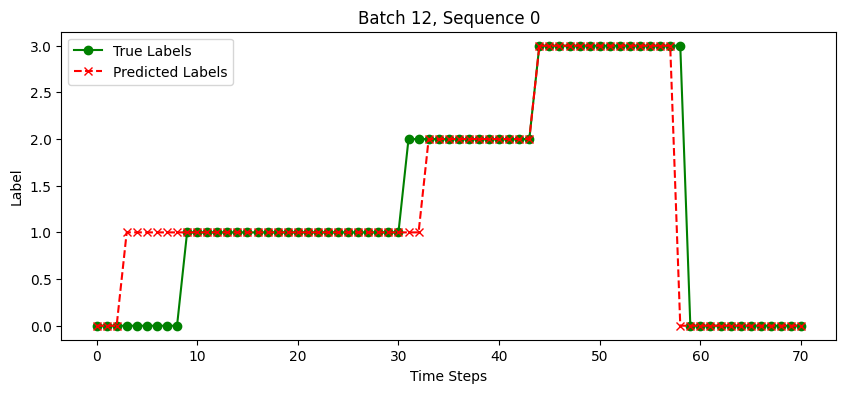

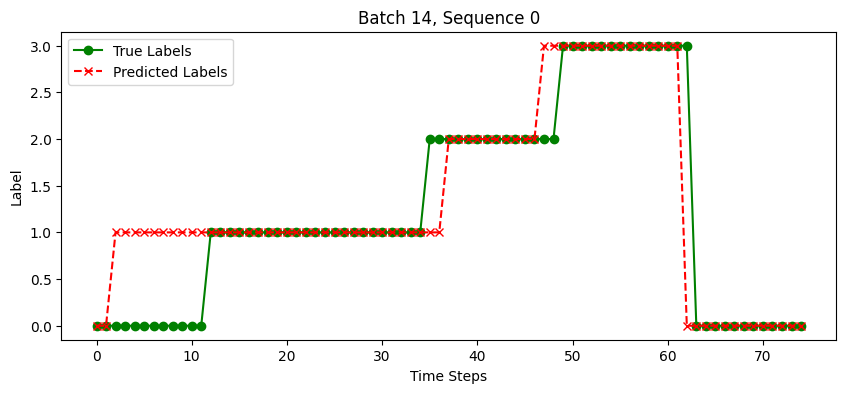

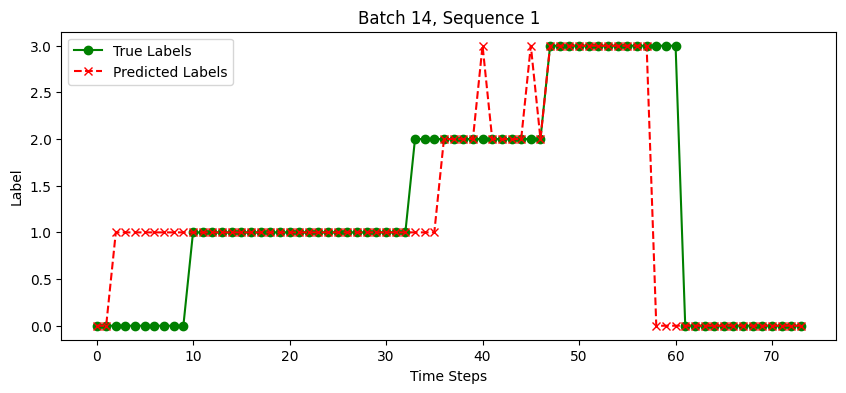

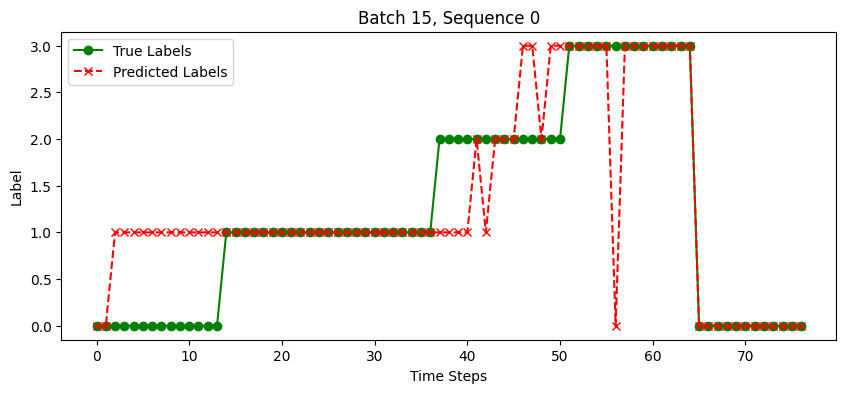

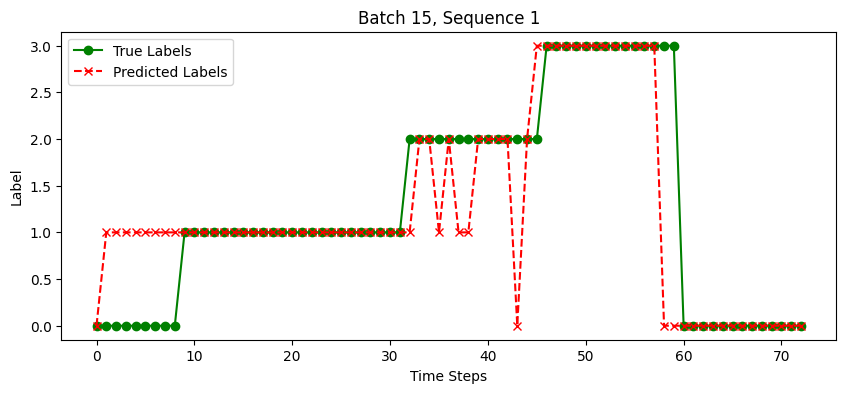

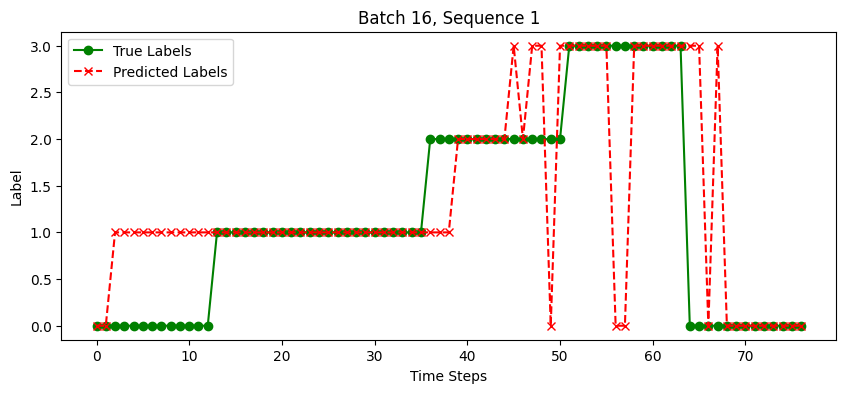

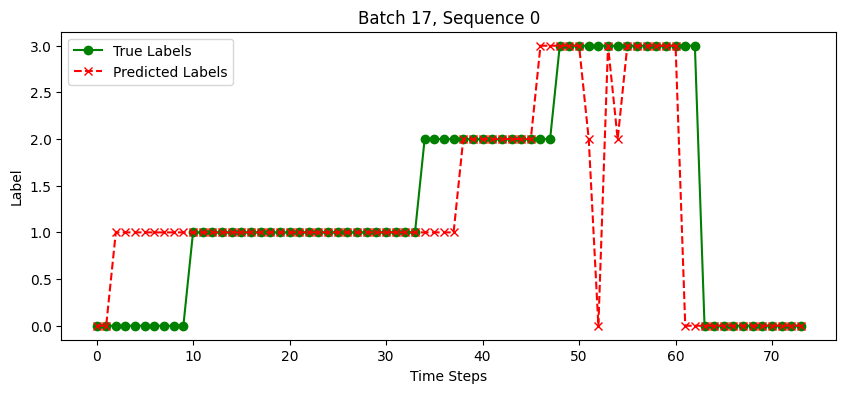

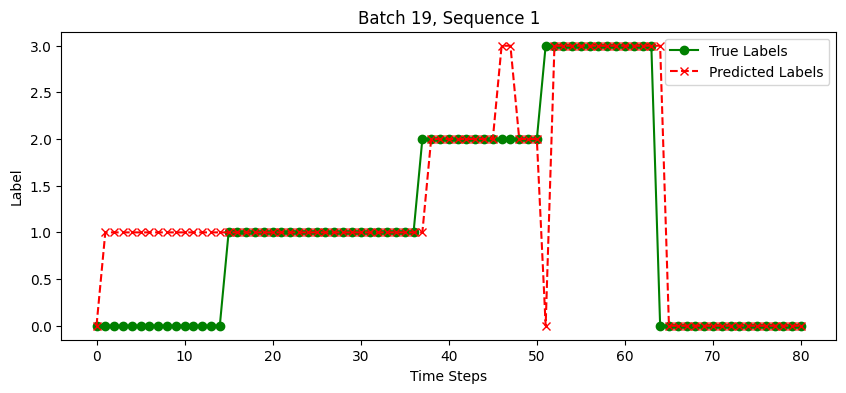

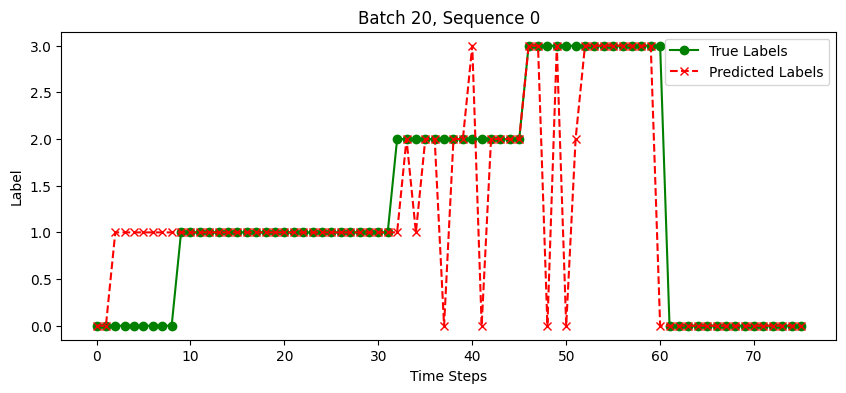

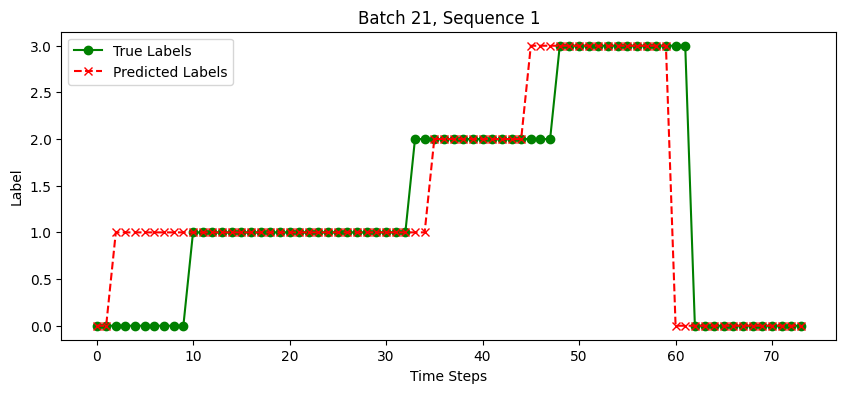

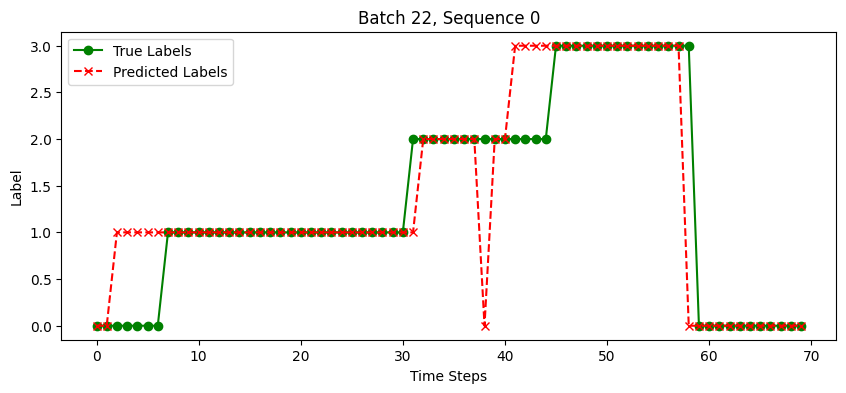

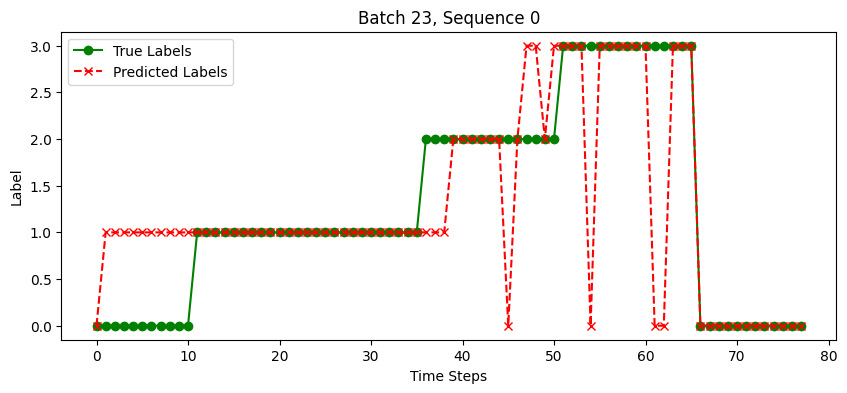

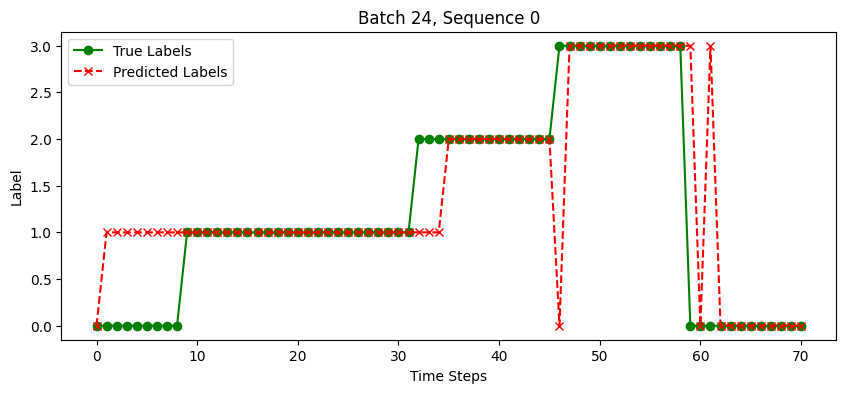

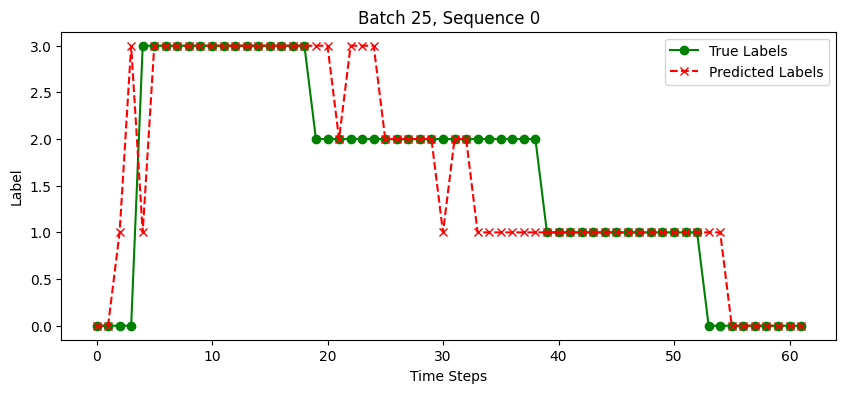

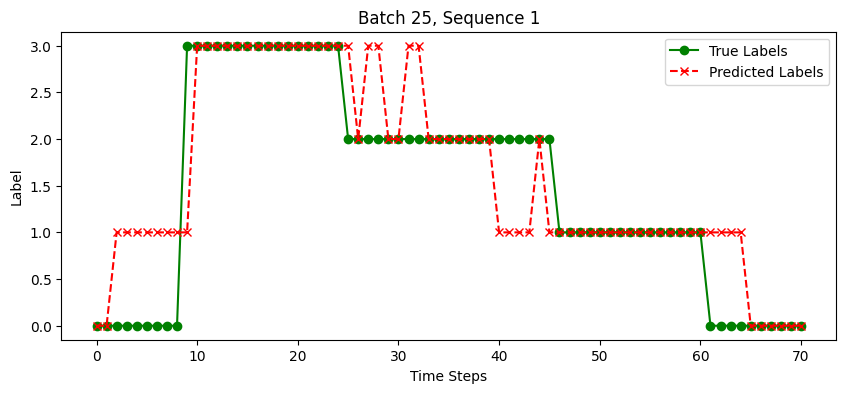

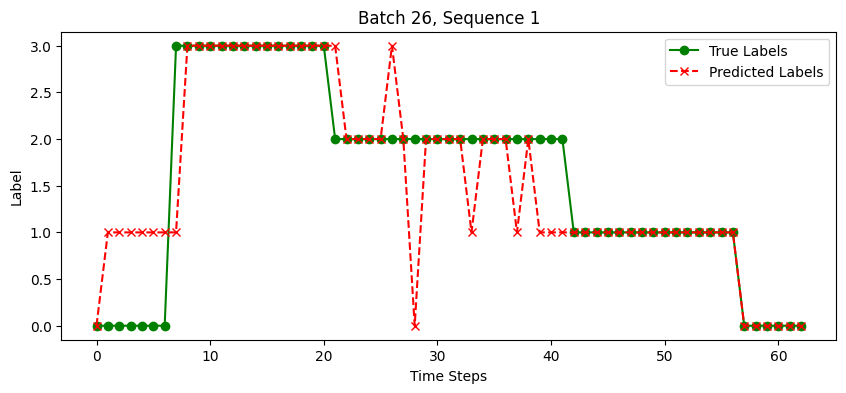

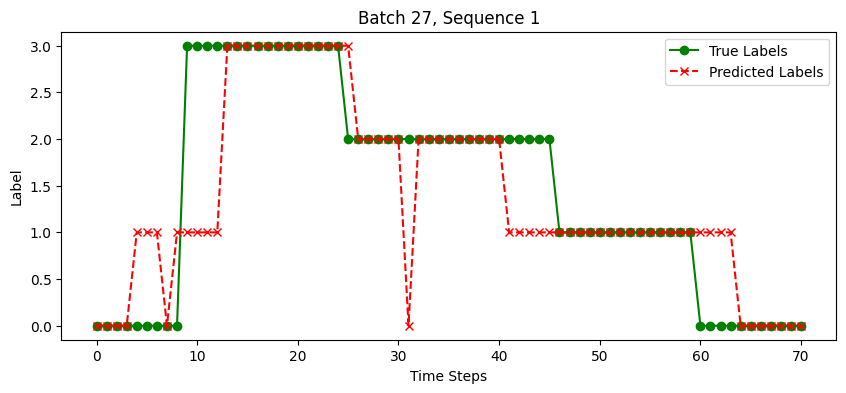

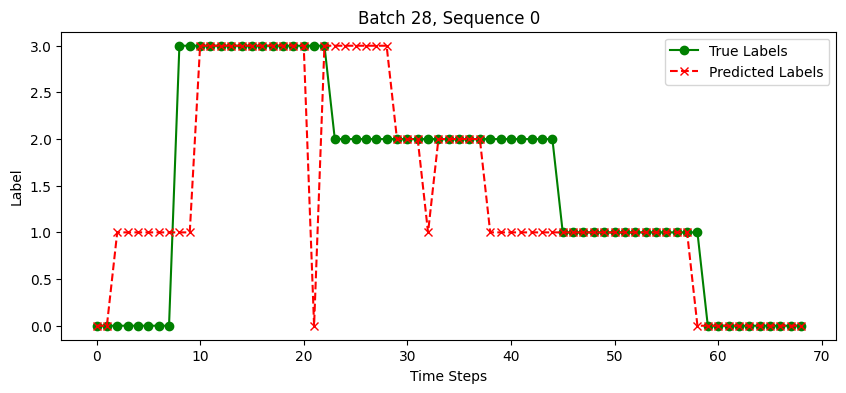

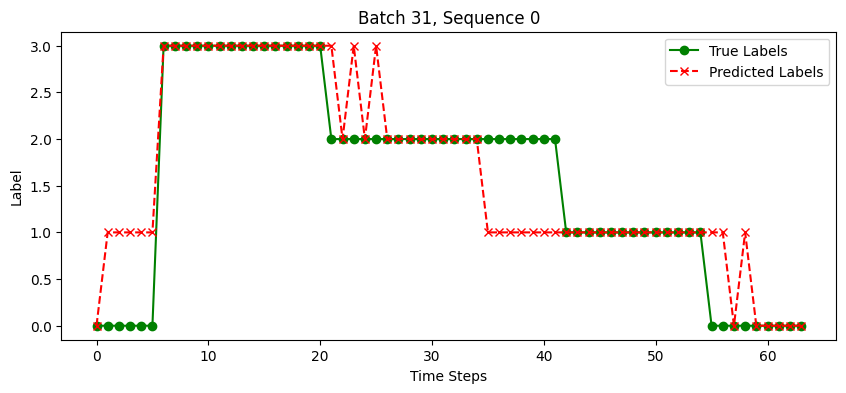

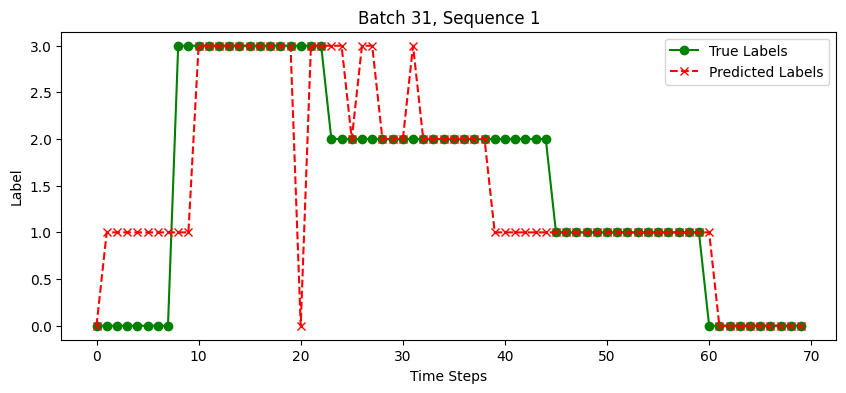

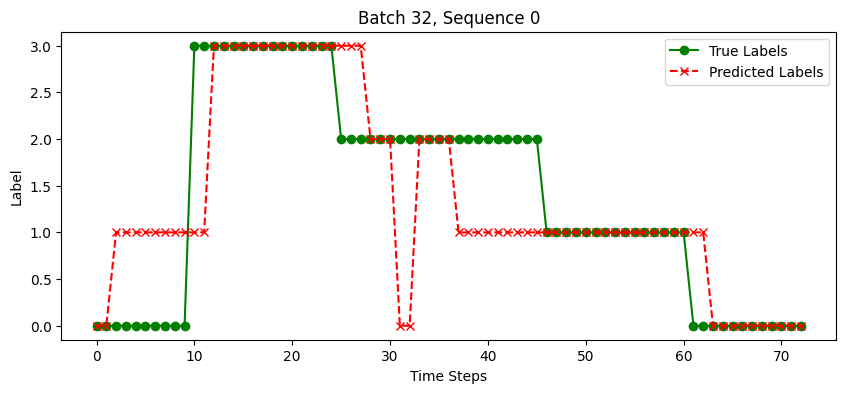

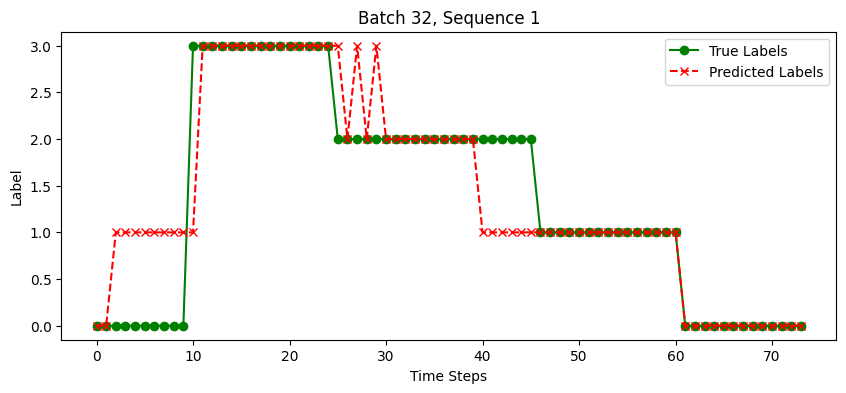

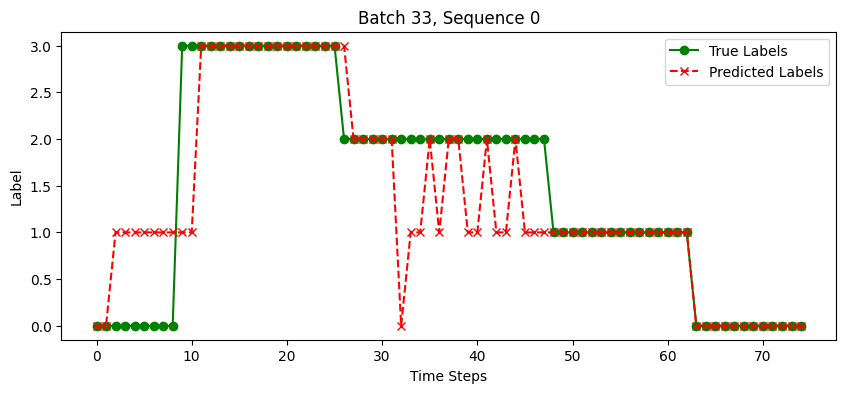

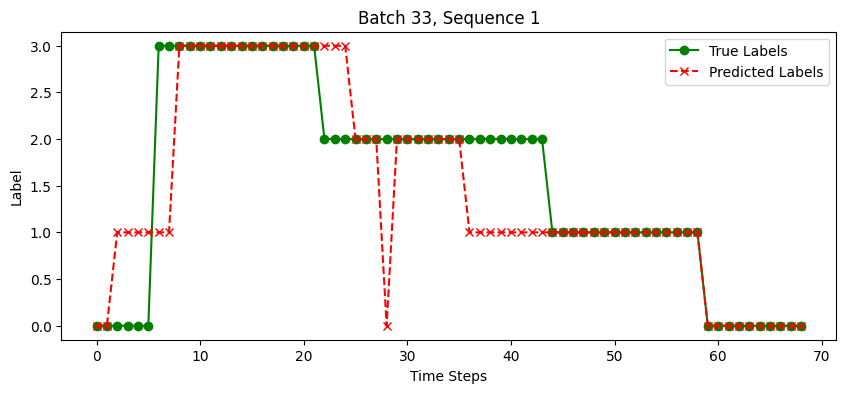

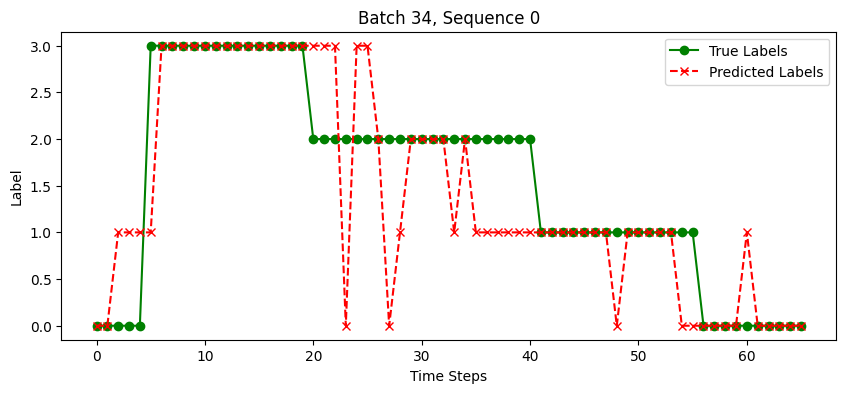

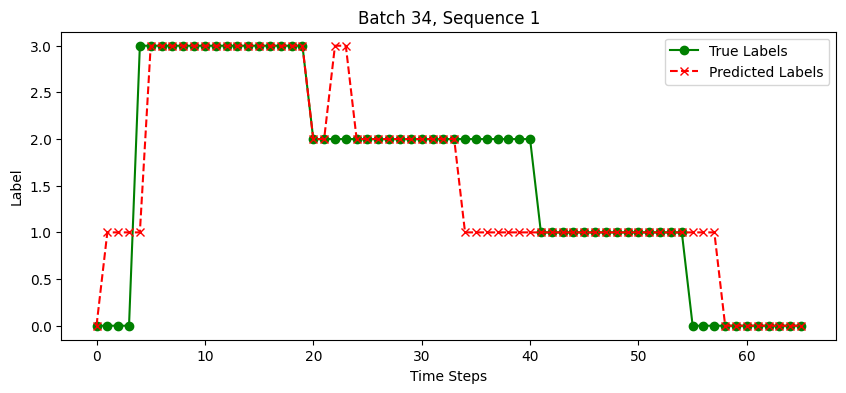

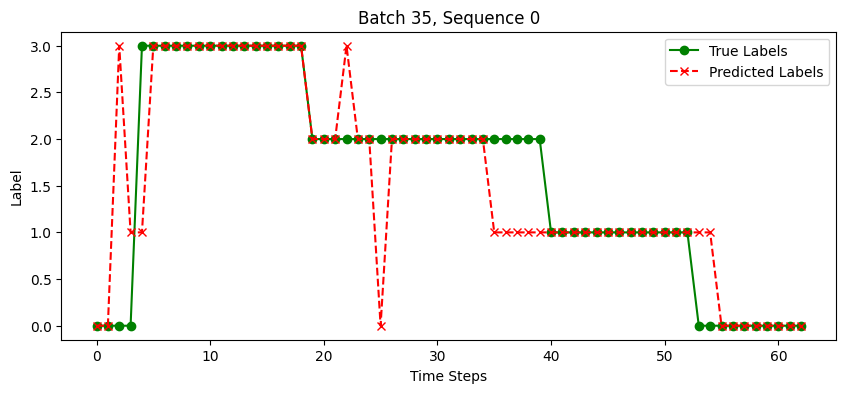

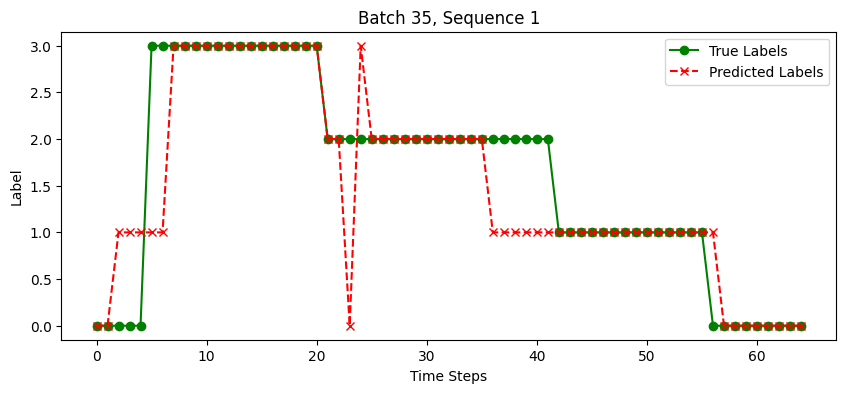

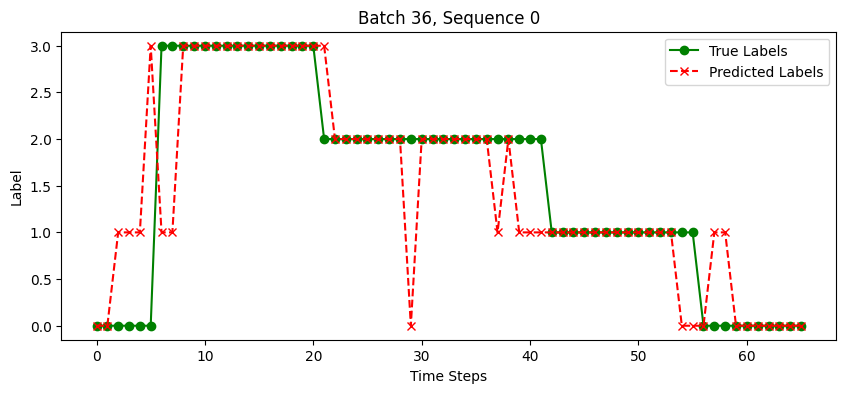

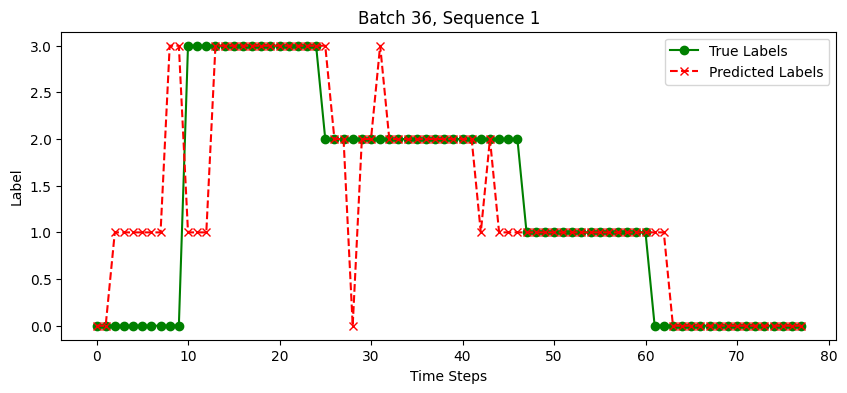

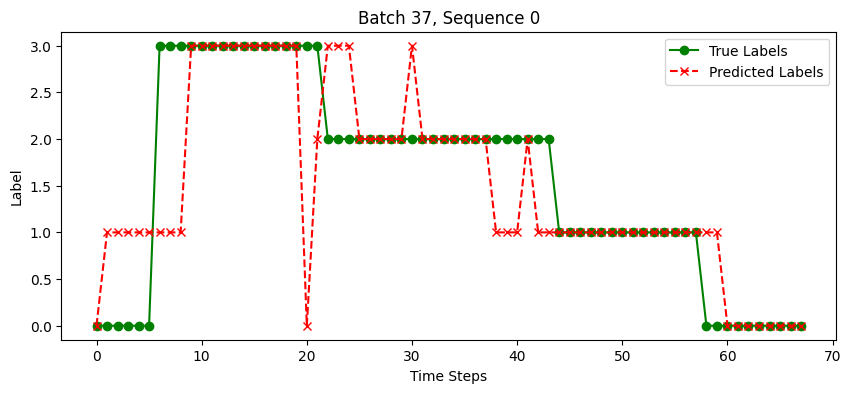

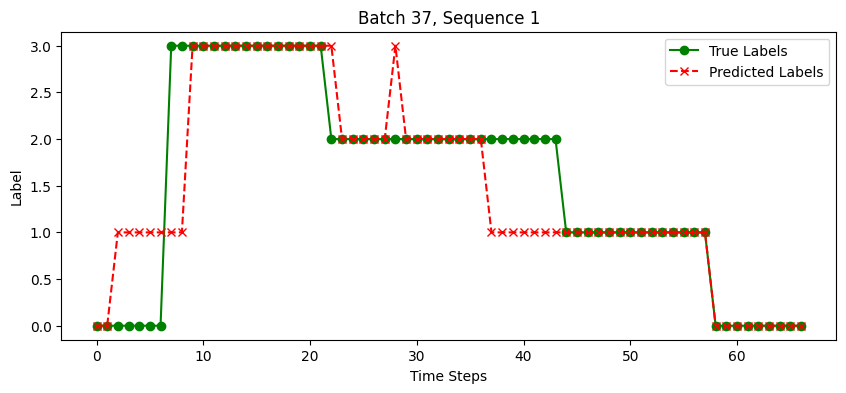

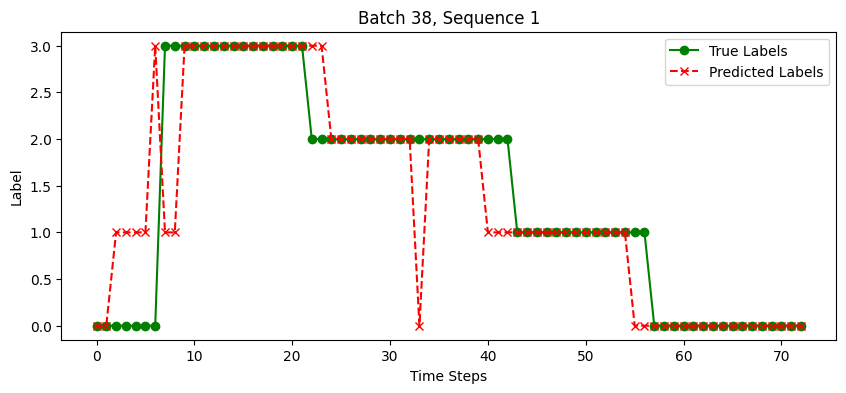

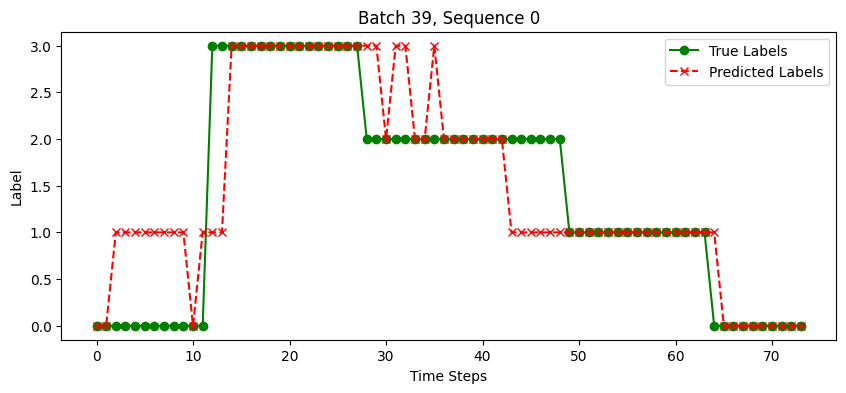

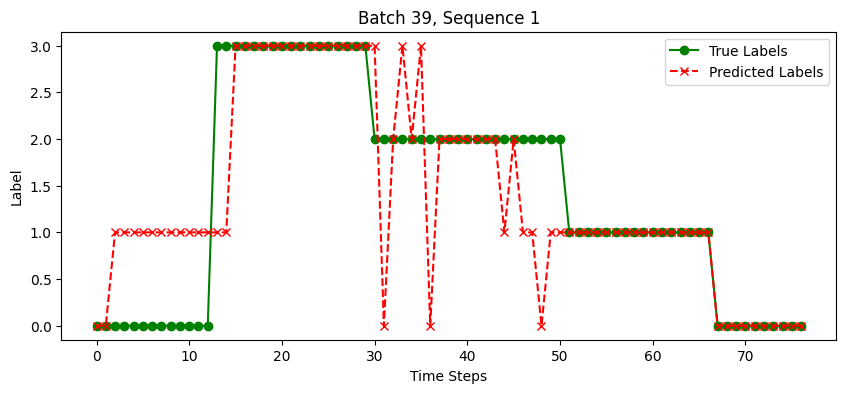

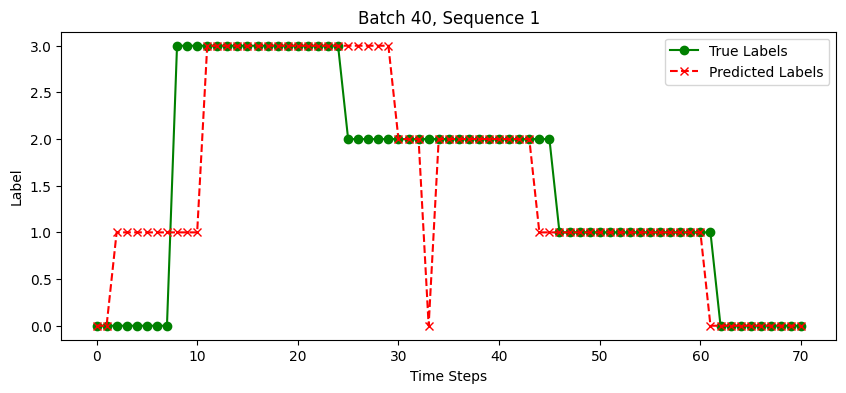

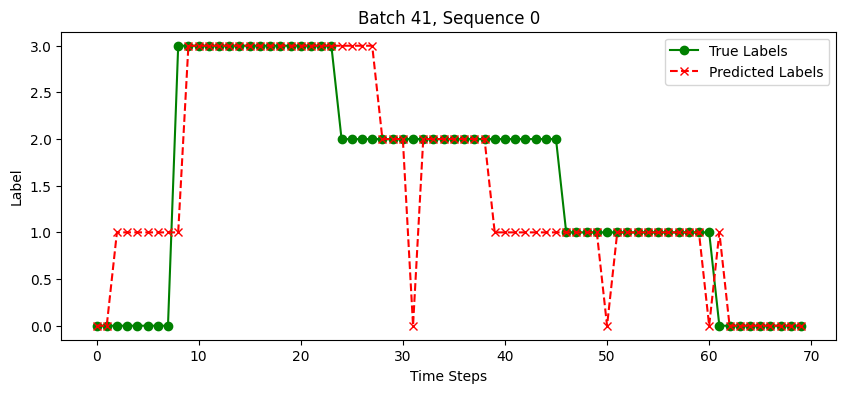

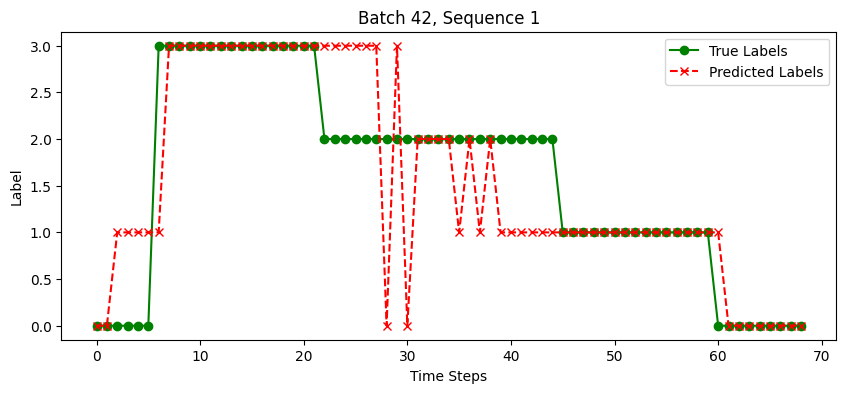

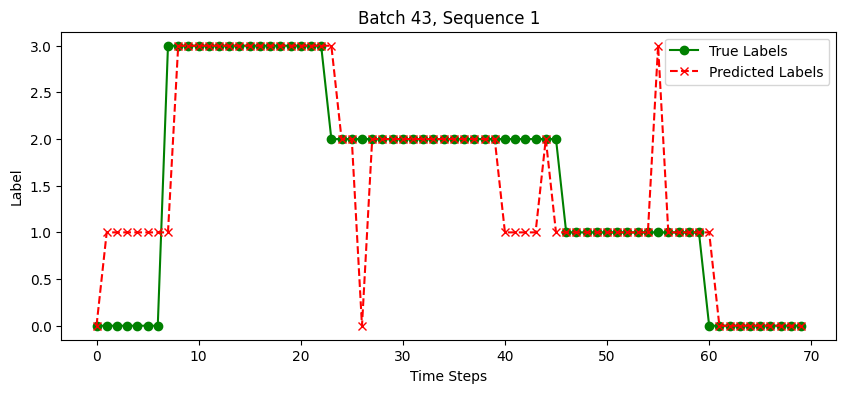

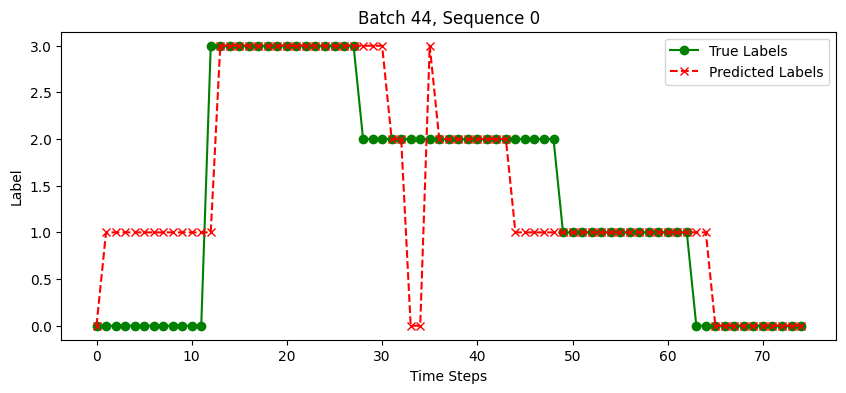

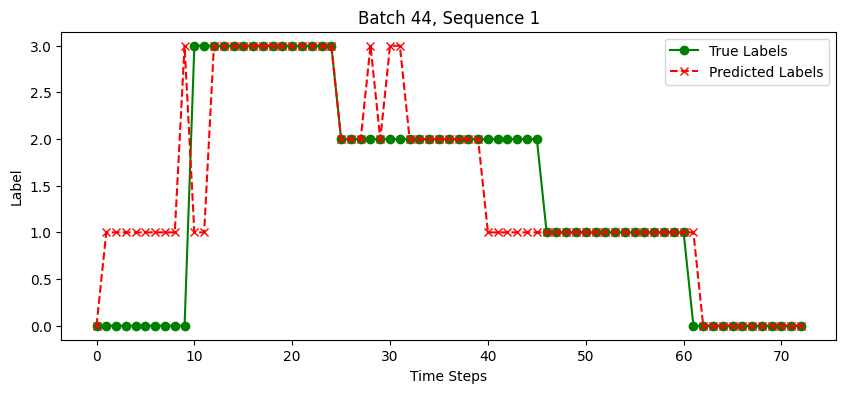

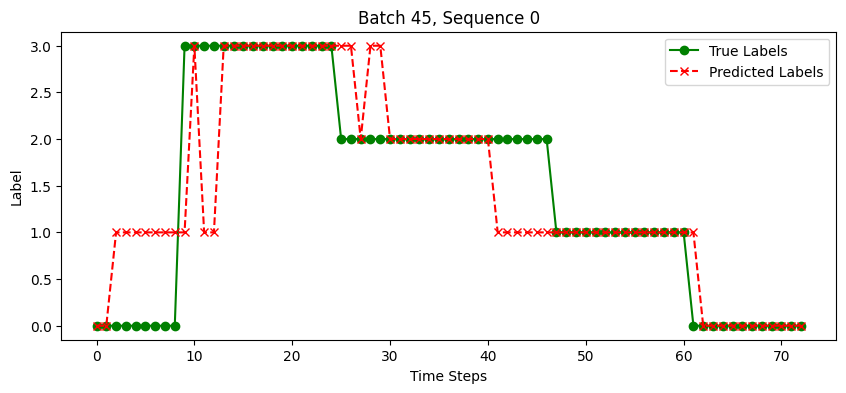

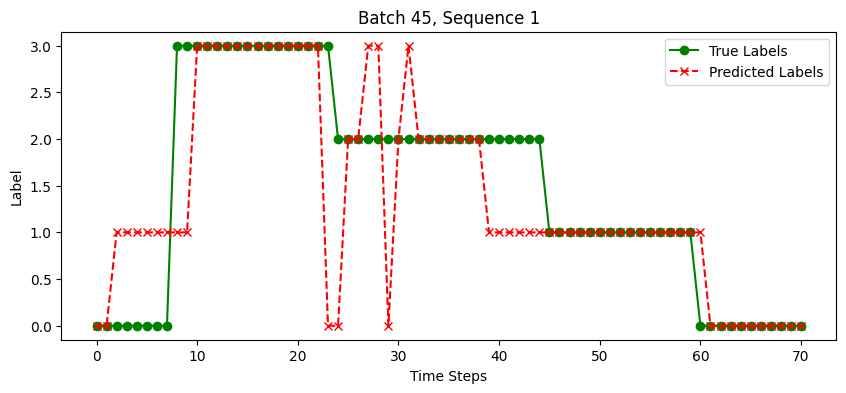

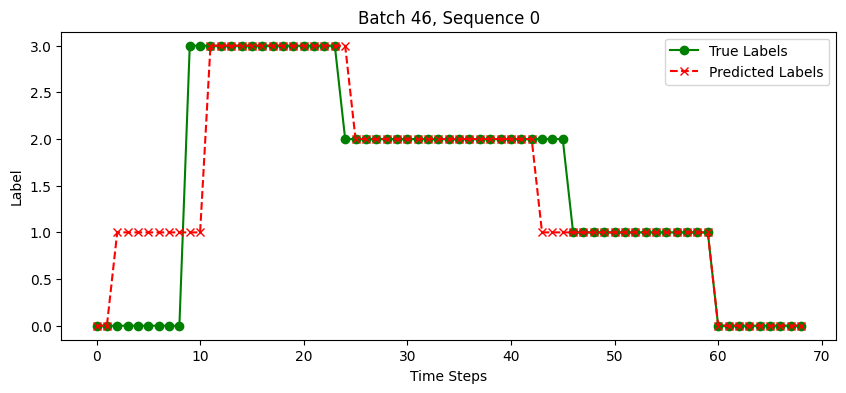

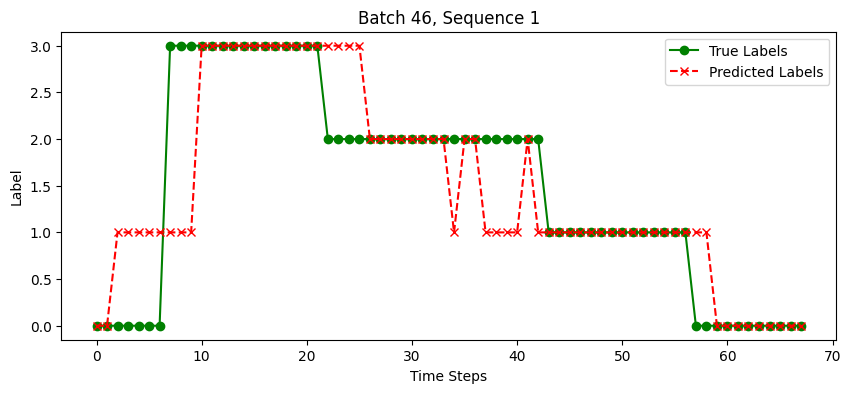

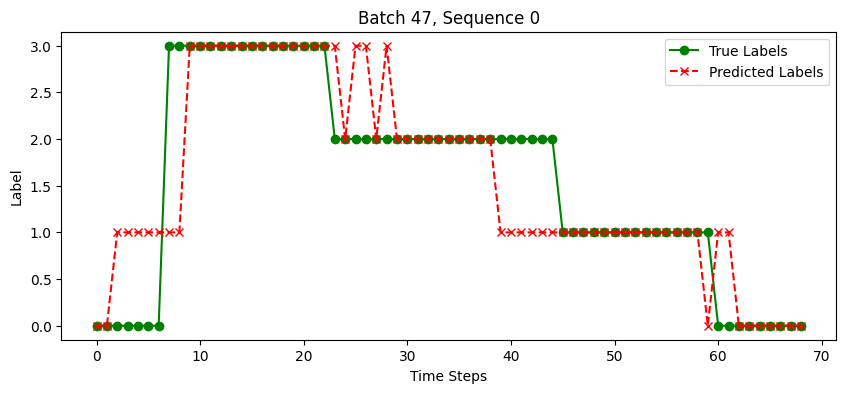

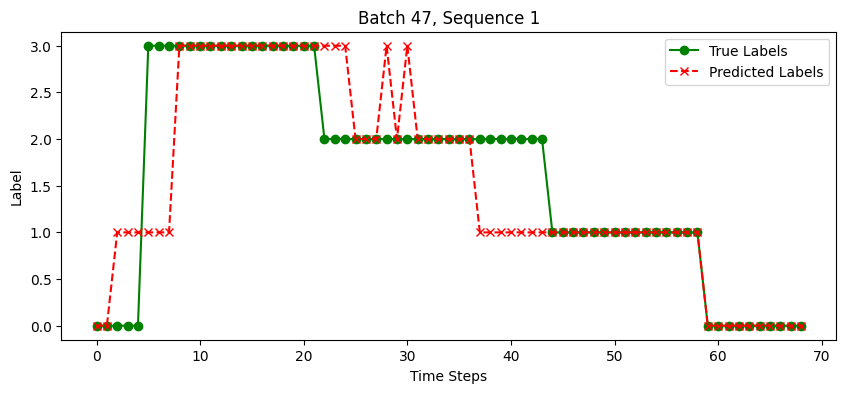

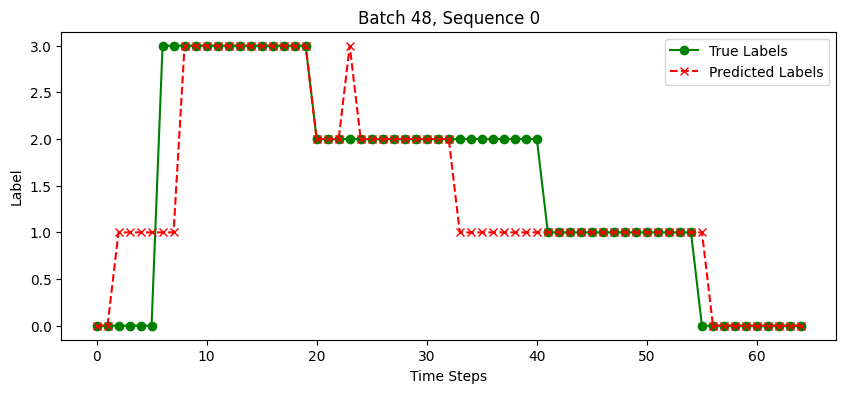

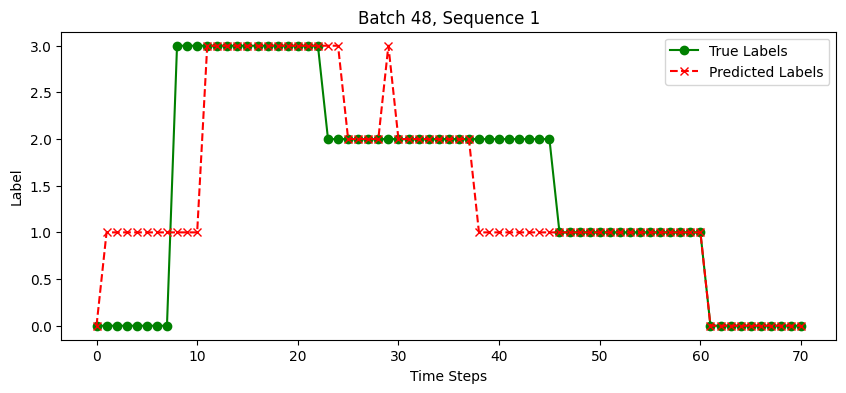

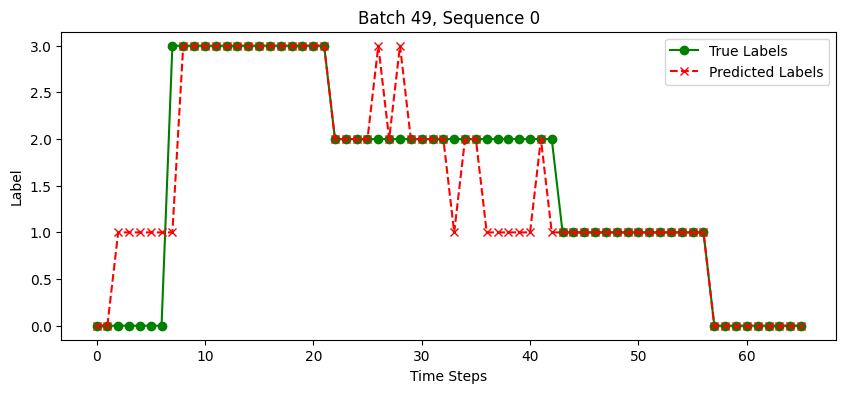

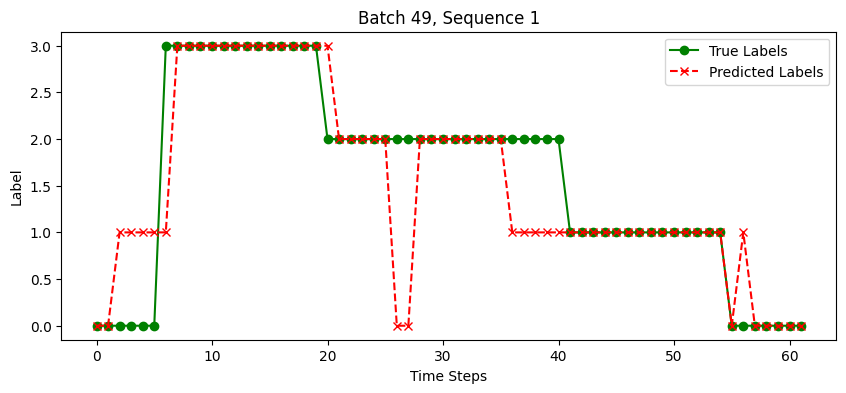

In [10]:
data_dirs = ["/home/nishimura-k/audioprocessing/datas/npy_MUSIC/EF/EF_ltor_150_60to109", "/home/nishimura-k/audioprocessing/datas/npy_MUSIC/EF/EF_rtol_150_60to109"]
label_dirs = ["/home/nishimura-k/audioprocessing/datas/npy_AREA_label/EF/EF_ltor_150_60to109", "/home/nishimura-k/audioprocessing/datas/npy_AREA_label/EF/EF_rtol_150_60to109"]


data_transform = DataToTensor()
label_transform = LabelMappingTransform()
batch_size = 2

test_dataset = Sequential2DDatasetWithLabels(data_dirs=data_dirs, label_dirs=label_dirs, transform=data_transform, labels_transform=label_transform)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# モデルの評価結果を可視化
model = CNNLSTMClassifier(hidden_size, output_size).to(device)
model.load_state_dict(torch.load("/home/nishimura-k/audioprocessing/algo_ml/EF_trimed_CNNLSTMClassifier/CNNLSTMClassifier4.pth"))
model.eval()
running_val_loss = 0.0
correct, total = 0, 0

seq_acc_list = [0] * 200
seq_count_list = [0] * 200
x = 100

error_place = {
  "ansLbutC": 0,
  "ansLbutR": 0,
  "ansLbutN": 0,
  "ansRbutC": 0,
  "ansRbutL": 0,
  "ansRbutN": 0,
  "ansCbutL": 0,
  "ansCbutR": 0,
  "ansCbutN": 0,
  "ansNbutL": 0,
  "ansNbutR": 0,
  "ansNbutC": 0
}

with torch.no_grad():
  for i, (inputs, labels, lengths) in enumerate(test_dataloader):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs, lengths)

    val_loss = criterion(outputs.view(-1, output_size), labels.view(-1))
    running_val_loss += val_loss.item()

    _, predicted = torch.max(outputs, -1)
    valid_mask = labels != -1

    # 時間ステップ毎の正解率を算出
    for batch_idx in range(inputs.size(0)):
      acc_list = []
      index_odds = 0
      index_odds_flag = False
      for index, value in enumerate(predicted[batch_idx]):
        num = 0
        if labels[batch_idx][index] == label_mapping["center"]:
          index_odds_flag = True

        if labels[batch_idx][index] == value:
          num += 1
        acc_list.append(num)

        if not index_odds_flag:
          index_odds += 1

      start_index = x - index_odds
      for j, v in enumerate(acc_list):
        seq_count_list[start_index+j] += 1
        if v == 1:
          seq_acc_list[start_index+j] += 1

    # 時間ステップ毎の
    for batch_idx in range(inputs.size(0)):
      for index, value in enumerate(predicted[batch_idx]):
        if labels[batch_idx][index] == label_mapping["left"] and value == label_mapping["center"]:
          error_place["ansLbutC"] += 1
        if labels[batch_idx][index] == label_mapping["left"] and value == label_mapping["right"]:
          error_place["ansLbutR"] += 1
        if labels[batch_idx][index] == label_mapping["left"] and value == label_mapping["none"]:
          error_place["ansLbutN"] += 1
        if labels[batch_idx][index] == label_mapping["right"] and value == label_mapping["center"]:
          error_place["ansRbutC"] += 1
        if labels[batch_idx][index] == label_mapping["right"] and value == label_mapping["left"]:
          error_place["ansRbutL"] += 1
        if labels[batch_idx][index] == label_mapping["right"] and value == label_mapping["none"]:
          error_place["ansRbutN"] += 1
        if labels[batch_idx][index] == label_mapping["center"] and value == label_mapping["left"]:
          error_place["ansCbutL"] += 1
        if labels[batch_idx][index] == label_mapping["center"] and value == label_mapping["right"]:
          error_place["ansCbutR"] += 1
        if labels[batch_idx][index] == label_mapping["center"] and value == label_mapping["none"]:
          error_place["ansCbutN"] += 1
        if labels[batch_idx][index] == label_mapping["none"] and value == label_mapping["center"]:
          error_place["ansNbutC"] += 1
        if labels[batch_idx][index] == label_mapping["none"] and value == label_mapping["left"]:
          error_place["ansNbutL"] += 1
        if labels[batch_idx][index] == label_mapping["none"] and value == label_mapping["right"]:
          error_place["ansNbutR"] += 1

    correct += (predicted[valid_mask] == labels[valid_mask]).sum().item()
    total += valid_mask.sum().item()

seq_start_idx = None
seq_end_idx = None
for i, seq_count in enumerate(seq_count_list):
  if seq_count < 30 and seq_end_idx is None and seq_start_idx is not None:
    seq_end_idx = i
  if seq_count >=30:
    if seq_start_idx is None:
      seq_start_idx = i
    seq_acc_list[i] = seq_acc_list[i] / seq_count
    if seq_acc_list[i] > 1:
      print(f"seq_acc_list[i]: {seq_acc_list}")
      print(f"seq_count: {seq_count}")
      print(f"i: {i}")

print("error_place:")
print(error_place)

time_list = [(i - x) * 0.192 for i in range(200)]
time_list = time_list[seq_start_idx:seq_end_idx]
seq_acc_list = seq_acc_list[seq_start_idx:seq_end_idx]
plt.figure(figsize=(10, 4))
plt.plot(time_list, seq_acc_list, label='Accuracy', color='g', marker='o')
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.title(f'Accuracy to timestep')
plt.legend()
plt.show()

print(len(test_dataloader))
avg_val_loss = running_val_loss / len(test_dataloader)
val_loss_list.append(avg_val_loss)
accuracy = 100 * correct / total
print(f"Valid Loss: {avg_val_loss}")
print(f"Validation accuracy: {accuracy}%")

visualize_predictions(model, test_dataloader, device)


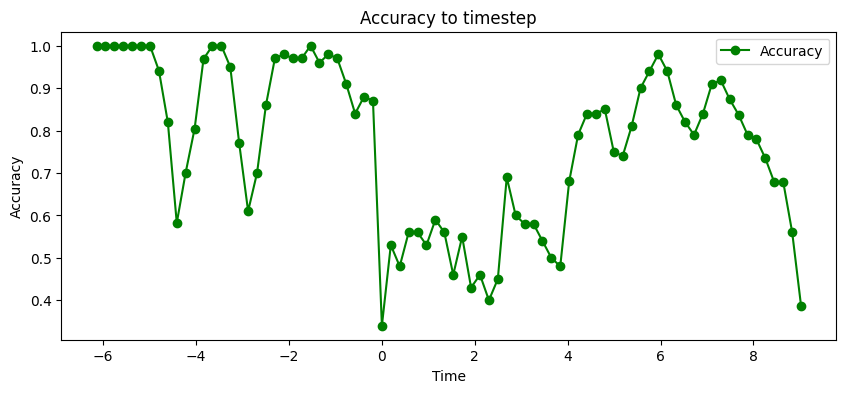

50
error_place:
{'ansLbutC': 0.0016411378555798686, 'ansLbutR': 0.0016411378555798686, 'ansLbutN': 0.14824945295404815, 'ansRbutC': 0.002631578947368421, 'ansRbutL': 0.0, 'ansRbutN': 0.16842105263157894, 'ansCbutL': 0.21635094715852443, 'ansCbutR': 0.2951146560319043, 'ansCbutN': 0.48554336989032904, 'ansNbutL': 0.0039906883937479215, 'ansNbutR': 0.0036581310276022614, 'ansNbutC': 0.0}
Valid Loss: 0.6719524383544921
Validation accuracy: 78.14207650273224%


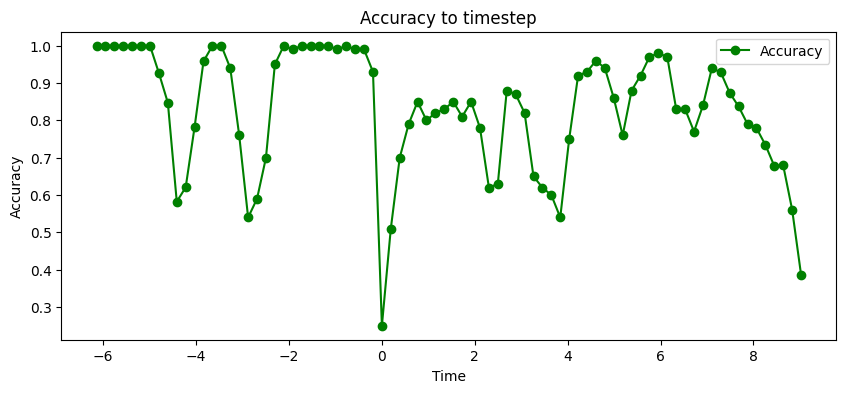

50
error_place:
{'ansLbutC': 0.004923413566739606, 'ansLbutR': 0.0038293216630196935, 'ansLbutN': 0.09901531728665208, 'ansRbutC': 0.011842105263157895, 'ansRbutL': 0.0006578947368421052, 'ansRbutN': 0.14473684210526316, 'ansCbutL': 0.24227318045862412, 'ansCbutR': 0.24825523429710866, 'ansCbutN': 0.0967098703888335, 'ansNbutL': 0.004655803126039242, 'ansNbutR': 0.004655803126039242, 'ansNbutC': 0.0}
Valid Loss: 0.4174478507041931
Validation accuracy: 85.24590163934427%


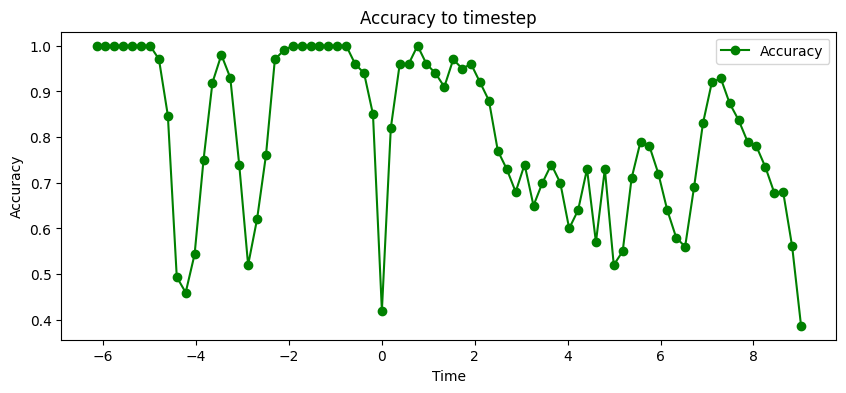

50
error_place:
{'ansLbutC': 0.03172866520787746, 'ansLbutR': 0.008205689277899343, 'ansLbutN': 0.27461706783369805, 'ansRbutC': 0.05197368421052632, 'ansRbutL': 0.0, 'ansRbutN': 0.2506578947368421, 'ansCbutL': 0.06181455633100698, 'ansCbutR': 0.07278165503489531, 'ansCbutN': 0.07676969092721835, 'ansNbutL': 0.0003325573661456601, 'ansNbutR': 0.0013302294645826404, 'ansNbutC': 0.0}
Valid Loss: 0.5755882239341736
Validation accuracy: 82.45761524450049%


50
error_place:
{'ansLbutC': 0.0, 'ansLbutR': 0.0010940919037199124, 'ansLbutN': 0.0962800875273523, 'ansRbutC': 0.014473684210526316, 'ansRbutL': 0.003289473684210526, 'ansRbutN': 0.19736842105263158, 'ansCbutL': 0.2971086739780658, 'ansCbutR': 0.16151545363908276, 'ansCbutN': 0.12662013958125623, 'ansNbutL': 0.007648819421350183, 'ansNbutR': 0.0016627868307283007, 'ansNbutC': 0.0}
Valid Loss: 0.4989879596233368
Validation accuracy: 84.30713184811546%


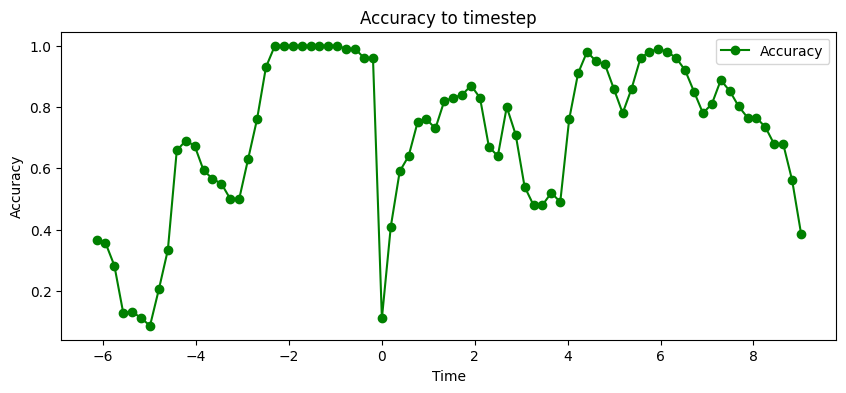

50
error_place:
{'ansLbutC': 0.0, 'ansLbutR': 0.0005470459518599562, 'ansLbutN': 0.009846827133479213, 'ansRbutC': 0.005263157894736842, 'ansRbutL': 0.060526315789473685, 'ansRbutN': 0.0625, 'ansCbutL': 0.4267198404785643, 'ansCbutR': 0.259222333000997, 'ansCbutN': 0.054835493519441676, 'ansNbutL': 0.2467575656800798, 'ansNbutR': 0.006983704689058862, 'ansNbutC': 0.0003325573661456601}
Valid Loss: 0.7682241690158844
Validation accuracy: 75.88622670589884%
defaultdict(<class 'float'>, {'ansLbutC': 0.007658643326039387, 'ansLbutR': 0.003063457330415755, 'ansLbutN': 0.12560175054704595, 'ansRbutC': 0.017236842105263158, 'ansRbutL': 0.012894736842105264, 'ansRbutN': 0.16473684210526315, 'ansCbutL': 0.24885343968095713, 'ansCbutR': 0.2073778664007976, 'ansCbutN': 0.16809571286141572, 'ansNbutL': 0.05267708679747256, 'ansNbutR': 0.0036581310276022614, 'ansNbutC': 6.651147322913202e-05})


In [11]:
from collections import defaultdict

data_dirs = ["/home/nishimura-k/audioprocessing/datas/npy_MUSIC/EF/EF_ltor_150_60to109", "/home/nishimura-k/audioprocessing/datas/npy_MUSIC/EF/EF_rtol_150_60to109"]
label_dirs = ["/home/nishimura-k/audioprocessing/datas/npy_AREA_label/EF/EF_ltor_150_60to109", "/home/nishimura-k/audioprocessing/datas/npy_AREA_label/EF/EF_rtol_150_60to109"]


data_transform = DataToTensor()
label_transform = LabelMappingTransform()
batch_size = 2

test_dataset = Sequential2DDatasetWithLabels(data_dirs=data_dirs, label_dirs=label_dirs, transform=data_transform, labels_transform=label_transform)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)



# モデルの評価結果を可視化
error_place_list = []
direction_count = {
  "left": 0,
  "right": 0,
  "center": 0,
  "none" : 0
}

for fold in range(5):
  model = CNNLSTMClassifier(hidden_size, output_size).to(device)
  model.load_state_dict(torch.load(f"/home/nishimura-k/audioprocessing/algo_ml/EF_trimed_CNNLSTMClassifier/CNNLSTMClassifier{fold}.pth"))
  model.eval()
  running_val_loss = 0.0
  correct, total = 0, 0

  seq_acc_list = [0] * 200
  seq_count_list = [0] * 200
  x = 100



  error_place = {
    "ansLbutC": 0,
    "ansLbutR": 0,
    "ansLbutN": 0,
    "ansRbutC": 0,
    "ansRbutL": 0,
    "ansRbutN": 0,
    "ansCbutL": 0,
    "ansCbutR": 0,
    "ansCbutN": 0,
    "ansNbutL": 0,
    "ansNbutR": 0,
    "ansNbutC": 0
  }

  with torch.no_grad():
    for i, (inputs, labels, lengths) in enumerate(test_dataloader):
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs, lengths)

      val_loss = criterion(outputs.view(-1, output_size), labels.view(-1))
      running_val_loss += val_loss.item()

      _, predicted = torch.max(outputs, -1)
      valid_mask = labels != -1

      # 時間ステップ毎の正解率を算出
      for batch_idx in range(inputs.size(0)):
        acc_list = []
        index_odds = 0
        index_odds_flag = False
        for index, value in enumerate(predicted[batch_idx]):
          num = 0
          if labels[batch_idx][index] == label_mapping["center"]:
            index_odds_flag = True

          if labels[batch_idx][index] == value:
            num += 1
          acc_list.append(num)

          if not index_odds_flag:
            index_odds += 1

        start_index = x - index_odds
        for j, v in enumerate(acc_list):
          seq_count_list[start_index+j] += 1
          if v == 1:
            seq_acc_list[start_index+j] += 1

      if fold == 0:
        for batch_idx in range(inputs.size(0)):
          for index, value in enumerate(predicted[batch_idx]):
            if value == label_mapping["left"]:
              direction_count["left"] += 1
            if value == label_mapping["right"]:
              direction_count["right"] += 1
            if value == label_mapping["center"]:
              direction_count["center"] += 1
            if value == label_mapping["none"]:
              direction_count["none"] += 1

      # 時間ステップ毎の間違いをカウント
      for batch_idx in range(inputs.size(0)):
        for index, value in enumerate(predicted[batch_idx]):
          if labels[batch_idx][index] == label_mapping["left"] and value == label_mapping["center"]:
            error_place["ansLbutC"] += 1
          if labels[batch_idx][index] == label_mapping["left"] and value == label_mapping["right"]:
            error_place["ansLbutR"] += 1
          if labels[batch_idx][index] == label_mapping["left"] and value == label_mapping["none"]:
            error_place["ansLbutN"] += 1
          if labels[batch_idx][index] == label_mapping["right"] and value == label_mapping["center"]:
            error_place["ansRbutC"] += 1
          if labels[batch_idx][index] == label_mapping["right"] and value == label_mapping["left"]:
            error_place["ansRbutL"] += 1
          if labels[batch_idx][index] == label_mapping["right"] and value == label_mapping["none"]:
            error_place["ansRbutN"] += 1
          if labels[batch_idx][index] == label_mapping["center"] and value == label_mapping["left"]:
            error_place["ansCbutL"] += 1
          if labels[batch_idx][index] == label_mapping["center"] and value == label_mapping["right"]:
            error_place["ansCbutR"] += 1
          if labels[batch_idx][index] == label_mapping["center"] and value == label_mapping["none"]:
            error_place["ansCbutN"] += 1
          if labels[batch_idx][index] == label_mapping["none"] and value == label_mapping["center"]:
            error_place["ansNbutC"] += 1
          if labels[batch_idx][index] == label_mapping["none"] and value == label_mapping["left"]:
            error_place["ansNbutL"] += 1
          if labels[batch_idx][index] == label_mapping["none"] and value == label_mapping["right"]:
            error_place["ansNbutR"] += 1

      correct += (predicted[valid_mask] == labels[valid_mask]).sum().item()
      total += valid_mask.sum().item()

  seq_start_idx = None
  seq_end_idx = None
  for i, seq_count in enumerate(seq_count_list):
    if seq_count < 30 and seq_end_idx is None and seq_start_idx is not None:
      seq_end_idx = i
    if seq_count >=30:
      if seq_start_idx is None:
        seq_start_idx = i
      seq_acc_list[i] = seq_acc_list[i] / seq_count
      if seq_acc_list[i] > 1:
        print(f"seq_acc_list[i]: {seq_acc_list}")
        print(f"seq_count: {seq_count}")
        print(f"i: {i}")

  for k in error_place.keys():
    if k.startswith("ansL"):
      error_place[k] = error_place[k] / direction_count["left"]
    if k.startswith("ansR"):
      error_place[k] = error_place[k] / direction_count["right"]
    if k.startswith("ansC"):
      error_place[k] = error_place[k] / direction_count["center"]
    if k.startswith("ansN"):
      error_place[k] = error_place[k] / direction_count["none"]
  error_place_list.append(error_place)

  time_list = [(i - x) * 0.192 for i in range(200)]
  time_list = time_list[seq_start_idx:seq_end_idx]
  seq_acc_list = seq_acc_list[seq_start_idx:seq_end_idx]
  plt.figure(figsize=(10, 4))
  plt.plot(time_list, seq_acc_list, label='Accuracy', color='g', marker='o')
  plt.xlabel('Time')
  plt.ylabel('Accuracy')
  plt.title(f'Accuracy to timestep')
  plt.legend()
  plt.show()

  print(len(test_dataloader))
  avg_val_loss = running_val_loss / len(test_dataloader)
  val_loss_list.append(avg_val_loss)
  accuracy = 100 * correct / total
  print("error_place:")
  print(error_place)
  print(f"Valid Loss: {avg_val_loss}")
  print(f"Validation accuracy: {accuracy}%")

mean_dic = defaultdict(float)
for error_place_dic in error_place_list:
  for key, value in error_place_dic.items():
    mean_dic[key] += value

for key, value in error_place_dic.items():
  mean_dic[key] = mean_dic[key] / len(error_place_list)
print(mean_dic)

In [26]:
np.mean([87.26790450928382, 90.25341130604288, 88.72832369942196, 90.0, 78.85085574572128])

87.02009905209398